## Notes

We are weighting based on time (more recent reports are weighted more heavily when fitting data).

We have scant data past early November, and data around that point in time is suffereing from delays in reporting.


In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

## Analysis of total cases

In [2]:
def seir(t, y, p):
    return [
        -p[1]*y[0]*y[2]/sum(y[:4]),
        p[1]*y[0]*y[2]/sum(y[:4]) - p[2]*y[1],
        p[2]*y[1] - p[0]*y[2],
        p[0]*y[2],
        p[2]*y[1]
    ]

In [3]:
the_data = pd.read_csv("../samoa/samoa-data/samoa_press_release_data.csv", header=0, dayfirst=True, parse_dates=True, skiprows=[1])
raw_times, raw_cumdata, H, cH, D, G = the_data.iloc[:,1:].values.T

In [4]:
start = 1
clip = None
times = raw_times[start:(-clip if clip else None)] + 33
cumdata = raw_cumdata[start:(-clip if clip else None)]

Text(0.5, 0, 'Days after 28 August 2019')

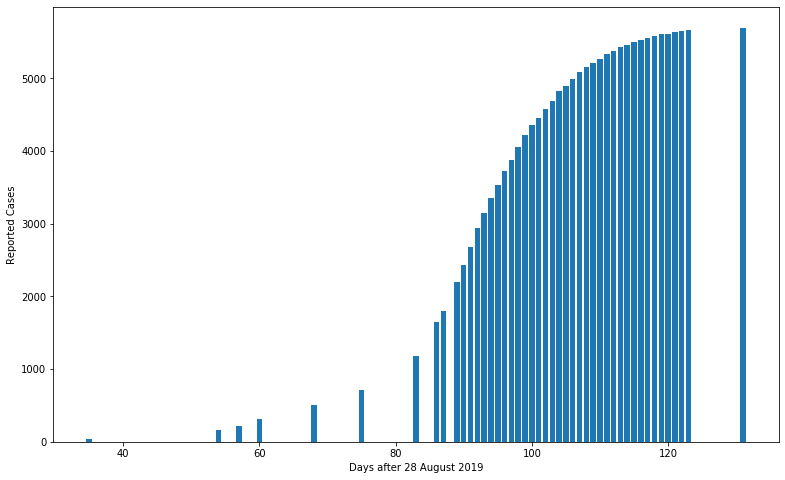

In [5]:
plt.figure(figsize=[13,8])
plt.bar(times, cumdata)
plt.ylabel("Reported Cases")
plt.xlabel("Days after 28 August 2019")

Text(0.5, 0, 'Days after 28 August 2019')

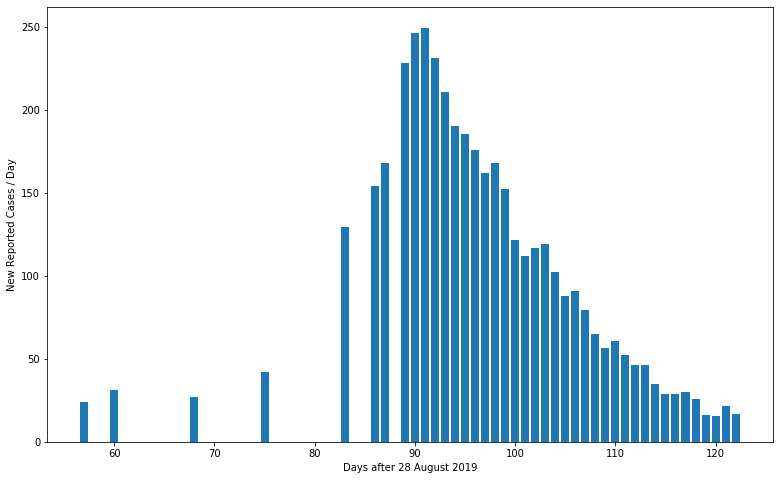

In [6]:
plt.figure(figsize=[13,8])
plt.bar(times, np.gradient(cumdata, times))
plt.ylabel("New Reported Cases / Day")
plt.xlabel("Days after 28 August 2019")

In [7]:
data_pd = np.array([[i] for i in cumdata])
p0 = [1/8, 1, 1/8]
config = {
    "grid_size": 100,
    "basis_number": 24,
    "model_form": {
        "state": 5,
        "parameters": 3
    },
    "time_span": [times[0], 150],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(times)},
    "observation_vector": [-1],
    "weightings":[
        [1]*5,
        np.sqrt(times/np.mean(times))
    ],
    "regularisation_value": copy(p0),
}

In [8]:
model = modeller.Model(config)
config['regularisation_value'][1] = model.ps[1]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 10,
        
    }
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [9]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [10]:
c0 = [max(cumdata)*np.ones(config['basis_number']) for _ in range(5)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*5) + [0]*len(config['regularisation_value'])
alpha = 1e3

In [11]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

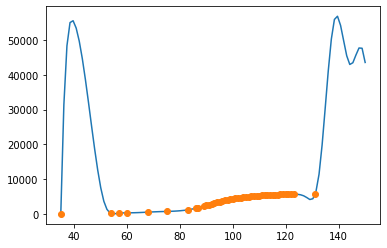

In [12]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[-1])
plt.plot(times, cumdata, 'o')

In [13]:
lbg = [0]*len(model.observation_times)*config['model_form']['state']
ubg = [140000]*len(model.observation_times)*config['model_form']['state']
# lbg[0] = 150000

In [14]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': lbg,
        'ubg': ubg
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du


Number of Iterations....: 87

                                   (scaled)                 (unscaled)
Objective...............:   9.4697826691949246e+01    9.4697826691949246e+01
Dual infeasibility......:   1.2372670896293535e-13    1.2372670896293535e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035695642638e-09    2.5059035695642638e-09
Overall NLP error.......:   2.5059035695642638e-09    2.5059035695642638e-09


Number of objective function evaluations             = 121
Number of objective gradient evaluations             = 88
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 121
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 88
Number of Lagrangian Hessian evaluations             = 87
Total CPU secs in IPOPT (w/o function evaluations)   =      0.166
Total CPU secs in NLP function evaluati

  30  9.4738273e+01 0.00e+00 1.26e-02  -8.6 5.42e+04 -12.2 2.38e-01 9.82e-02f  2
  40  9.4727121e+01 0.00e+00 9.78e-03  -8.6 4.39e+04 -13.4 2.75e-03 7.89e-03f  1
  50  9.4724283e+01 0.00e+00 6.72e-03  -8.6 1.77e+02 -12.7 1.00e+00 1.00e+00f  1

Number of Iterations....: 58

                                   (scaled)                 (unscaled)
Objective...............:   9.4724260115750539e+01    9.4724260115750539e+01
Dual infeasibility......:   2.6238443162476859e-10    2.6238443162476859e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059036888608494e-09    2.5059036888608494e-09
Overall NLP error.......:   2.5059036888608494e-09    2.5059036888608494e-09


Number of objective function evaluations             = 71
Number of objective gradient evaluations             = 59
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 71
Number of equality constraint Jacobia

  20  9.4746069e+01 0.00e+00 1.59e-02  -3.8 7.72e+03    -  1.00e+00 1.00e+00f  1
  30  9.4739473e+01 0.00e+00 3.26e-06  -8.6 9.30e+00  -7.8 1.00e+00 1.00e+00h  1
  40  9.4739408e+01 0.00e+00 7.18e-06  -8.6 2.49e+02 -12.6 1.00e+00 1.00e+00h  1
  50  9.4736274e+01 0.00e+00 2.58e-02  -8.6 5.06e+03 -12.8 1.00e+00 1.00e+00f  1
  60  9.4727218e+01 0.00e+00 6.53e-02  -8.6 1.12e+03    -  6.21e-05 4.74e-02f  1
  70  9.4726293e+01 0.00e+00 3.74e-04  -8.6 3.83e+03    -  4.88e-01 1.00e+00h  1
  80  9.4726293e+01 0.00e+00 4.78e-07  -8.6 7.40e+01 -16.1 1.00e+00 1.00e+00h  1

Number of Iterations....: 82

                                   (scaled)                 (unscaled)
Objective...............:   9.4726292572749088e+01    9.4726292572749088e+01
Dual infeasibility......:   7.5176583280852469e-11    7.5176583280852469e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059047029630983e-09    2.5059047029630983e-09
Overall NLP error......

  20  9.4765401e+01 0.00e+00 5.40e-04  -3.8 5.39e+02    -  1.00e+00 1.00e+00f  1
  30  9.4758590e+01 0.00e+00 2.27e-05  -8.6 9.64e+00  -8.3 1.00e+00 9.86e-01f  1
  40  9.4756309e+01 0.00e+00 1.00e-02  -8.6 1.96e+03 -12.2 1.00e+00 1.00e+00f  1
  50  9.4731787e+01 0.00e+00 3.42e-02  -8.6 1.97e+03 -11.5 1.00e+00 1.00e+00f  1
  60  9.4728014e+01 0.00e+00 5.19e-04  -8.6 8.32e+03    -  4.10e-01 5.00e-01h  2
  70  9.4728013e+01 0.00e+00 2.44e-04  -9.0 1.20e+05    -  5.96e-01 1.17e-01h  3

Number of Iterations....: 76

                                   (scaled)                 (unscaled)
Objective...............:   9.4728012930542675e+01    9.4728012930542675e+01
Dual infeasibility......:   1.4413885374816207e-11    1.4413885374816207e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    9.0909090909090931e-10
Overall NLP error.......:   9.0909090909090931e-10    9.0909090909090931e-10


Number of objective funct

                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.4732126e+01 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  9.8290846e+01 0.00e+00 2.59e+01  -1.7 2.00e+04    -  7.31e-01 1.00e+00f  1
  20  9.5010135e+01 0.00e+00 8.71e-02  -2.5 8.90e+02    -  1.00e+00 1.00e+00f  1
  30  9.4831655e+01 0.00e+00 1.01e-06  -8.6 2.73e-01  -5.4 1.00e+00 1.00e+00h  1
  40  9.4831445e+01 0.00e+00 1.12e-05  -8.6 2.68e+01 -10.2 1.00e+00 1.00e+00h  1
 

  60  9.4739664e+01 0.00e+00 1.74e-02  -8.6 5.51e+02 -10.6 6.18e-01 2.50e-01f  3
  70  9.4739495e+01 0.00e+00 2.20e-03  -8.6 5.30e+05    -  1.02e-01 1.99e-02h  4

Number of Iterations....: 79

                                   (scaled)                 (unscaled)
Objective...............:   9.4739493811464925e+01    9.4739493811464925e+01
Dual infeasibility......:   1.4282623370079155e-12    1.4282623370079155e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    2.5059035596800626e-09
Overall NLP error.......:   2.5059035596800626e-09    2.5059035596800626e-09


Number of objective function evaluations             = 128
Number of objective gradient evaluations             = 80
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 128
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 80
N

  70  9.4756377e+01 0.00e+00 1.11e-02  -8.6 4.76e+05    -  3.13e-02 8.08e-03f  6
  80  9.4756369e+01 0.00e+00 1.32e-02  -8.6 1.16e+05    -  5.13e-01 1.66e-01h  3

Number of Iterations....: 86

                                   (scaled)                 (unscaled)
Objective...............:   9.4756367531640720e+01    9.4756367531640720e+01
Dual infeasibility......:   4.7725006811283611e-10    4.7725006811283611e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059037115209990e-09    2.5059037115209990e-09
Overall NLP error.......:   2.5059037115209990e-09    2.5059037115209990e-09


Number of objective function evaluations             = 133
Number of objective gradient evaluations             = 87
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 133
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 87
N

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.4795248e+01 0.00e+00 1.02e+00  -1.0 0.00e+00    -  0.00e+00 0.

  40  9.4991822e+01 0.00e+00 9.68e+00  -3.8 1.03e+04 -10.8 4.78e-01 1.61e-01f  2
  50  9.4935837e+01 0.00e+00 8.12e-02  -5.7 5.85e+03    -  1.00e+00 1.00e+00f  1
  60  9.4935678e+01 0.00e+00 1.33e-04  -8.6 1.60e+03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 62

                                   (scaled)                 (unscaled)
Objective...............:   9.4935677864575140e+01    9.4935677864575140e+01
Dual infeasibility......:   4.3656815661635238e-09    4.3656815661635238e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.2755824493908099e-09    3.2755824493908099e-09
Overall NLP error.......:   4.3656815661635238e-09    4.3656815661635238e-09


Number of objective function evaluations             = 96
Number of objective gradient evaluations             = 63
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 96
Number of equality constraint Jacobia

  30  9.6258684e+01 0.00e+00 3.11e+01  -3.8 4.40e+02  -7.3 1.00e+00 1.00e+00f  1
  40  9.5211315e+01 0.00e+00 1.10e-03  -3.8 7.49e+01    -  1.00e+00 1.00e+00f  1
  50  9.5207916e+01 0.00e+00 1.94e-05  -8.6 1.93e+01    -  9.49e-01 1.00e+00h  1

Number of Iterations....: 54

                                   (scaled)                 (unscaled)
Objective...............:   9.5207916062614629e+01    9.5207916062614629e+01
Dual infeasibility......:   6.8362513218741261e-10    6.8362513218741261e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.9967809105534637e-10    9.9967809105534637e-10
Overall NLP error.......:   9.9967809105534637e-10    9.9967809105534637e-10


Number of objective function evaluations             = 81
Number of objective gradient evaluations             = 55
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 81
Number of equality constraint Jacobia

  30  9.5830448e+01 0.00e+00 6.13e-04  -5.7 1.04e+03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   9.5830397291868422e+01    9.5830397291868422e+01
Dual infeasibility......:   9.6023355985943025e-09    9.6023355985943025e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   7.4000453193220379e-09    7.4000453193220379e-09
Overall NLP error.......:   9.6023355985943025e-09    9.6023355985943025e-09


Number of objective function evaluations             = 60
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 60
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 38
Number of Lagrangian Hessian evaluations             = 37
Total CPU secs in IPOPT (w

  30  9.7239622e+01 0.00e+00 1.38e-05  -3.8 7.12e+00    -  1.00e+00 1.00e+00h  1
  40  9.7236845e+01 0.00e+00 3.54e-05  -8.6 4.51e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 42

                                   (scaled)                 (unscaled)
Objective...............:   9.7236844840618275e+01    9.7236844840618275e+01
Dual infeasibility......:   2.7796328048851942e-09    2.7796328048851942e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.2634300379585844e-09    3.2634300379585844e-09
Overall NLP error.......:   3.2634300379585844e-09    3.2634300379585844e-09


Number of objective function evaluations             = 53
Number of objective gradient evaluations             = 43
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 53
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 43
Num

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0207054e+02 0.00e+00 4.36e+00  -1.0 0.00e+00    -  0.00e+00 0.

  20  1.1549605e+02 0.00e+00 1.98e+00  -2.5 6.61e+02    -  1.00e+00 1.00e+00f  1
  30  1.1542859e+02 0.00e+00 1.18e-04  -8.6 1.19e-01  -7.8 1.00e+00 6.08e-01h  1

Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:   1.1542858543949232e+02    1.1542858543949232e+02
Dual infeasibility......:   3.9532803250851826e-09    3.9532803250851826e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   5.3262767852609010e-09    5.3262767852609010e-09
Overall NLP error.......:   5.3262767852609010e-09    5.3262767852609010e-09


Number of objective function evaluations             = 36
Number of objective gradient evaluations             = 34
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 36
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 34
Num

  20  1.3943157e+02 0.00e+00 1.14e-01  -2.5 3.73e+00  -5.0 1.00e+00 1.00e+00f  1
  30  1.3934866e+02 0.00e+00 4.46e-05  -5.7 2.53e-01  -5.9 1.00e+00 9.29e-01f  1

Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:   1.3934862538587501e+02    1.3934862538587501e+02
Dual infeasibility......:   3.5953859056375161e-09    3.5953859056375161e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.3502012309161538e-09    4.3502012309161538e-09
Overall NLP error.......:   4.3502012309161538e-09    4.3502012309161538e-09


Number of objective function evaluations             = 39
Number of objective gradient evaluations             = 37
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 39
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 37
Num


EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   3.04ms ( 26.02us)   3.17ms ( 27.11us)       117
       nlp_g  |   1.50ms ( 12.80us)   1.50ms ( 12.85us)       117
    nlp_grad  |  63.00us ( 63.00us)  63.26us ( 63.26us)         1
  nlp_grad_f  |   4.01ms ( 52.12us)   4.02ms ( 52.16us)        77
  nlp_hess_l  |  26.10ms (347.95us)  26.43ms (352.38us)        75
   nlp_jac_g  |   1.22ms ( 15.78us)   1.22ms ( 15.88us)        77
       total  | 173.14ms (173.14ms) 173.61ms (173.61ms)         1
Solving for p=2.009233002565046
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
         

  30  2.9491771e+02 0.00e+00 1.37e-05  -5.7 2.30e+01  -9.7 1.00e+00 1.00e+00h  1
  40  2.9488830e+02 0.00e+00 3.56e-01  -8.6 1.58e+02 -10.0 1.00e+00 1.00e+00f  1
  50  2.9482620e+02 0.00e+00 4.00e+01  -8.6 1.63e+03 -10.2 1.00e+00 5.00e-01f  2
  60  2.9474127e+02 0.00e+00 1.09e+02  -8.6 8.32e+02  -9.6 1.00e+00 1.00e+00f  1
  70  2.9454665e+02 0.00e+00 1.20e+02  -8.6 7.95e+02  -8.9 1.00e+00 4.85e-01f  2

Number of Iterations....: 77

                                   (scaled)                 (unscaled)
Objective...............:   2.9450526914889696e+02    2.9450526914889696e+02
Dual infeasibility......:   1.0463874758719350e-09    1.0463874758719350e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596811570e-09    2.5059035596811570e-09
Overall NLP error.......:   2.5059035596811570e-09    2.5059035596811570e-09


Number of objective function evaluations             = 128
Number of objective gradient evaluations       

  30  4.9310516e+02 0.00e+00 4.32e-01  -1.7 3.34e+00  -7.4 1.00e+00 1.00e+00f  1
  40  4.9301653e+02 0.00e+00 2.91e-01  -2.5 1.72e+02    -  1.00e+00 1.00e+00h  1
  50  4.9294130e+02 0.00e+00 2.63e+02  -5.7 1.64e+04 -11.7 1.00e+00 1.00e+00f  1
  60  4.9286703e+02 0.00e+00 2.06e+01  -5.7 2.54e+02  -9.3 1.00e+00 1.00e+00f  1
  70  4.9278753e+02 0.00e+00 2.40e+02  -5.7 8.80e+02  -9.5 1.00e+00 1.00e+00f  1
  80  4.9240159e+02 0.00e+00 8.38e+01  -5.7 2.82e+04  -8.9 1.00e+00 1.21e-02f  4
  90  4.9201858e+02 0.00e+00 1.99e-07  -5.7 1.16e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 92

                                   (scaled)                 (unscaled)
Objective...............:   4.9201857818410508e+02    4.9201857818410508e+02
Dual infeasibility......:   3.1136966657970510e-09    3.1136966657970510e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

  30  8.1533117e+02 0.00e+00 2.67e-04  -8.6 1.00e+01  -8.2 1.00e+00 1.00e+00f  1
  40  8.1504027e+02 0.00e+00 9.43e+00  -8.6 6.64e+02  -9.4 1.00e+00 1.00e+00f  1
  50  8.1476156e+02 0.00e+00 1.27e+00  -8.6 4.29e+01  -7.8 1.00e+00 1.00e+00f  1
  60  8.1427370e+02 0.00e+00 7.39e+01  -8.6 1.93e+02  -8.1 1.00e+00 1.00e+00f  1
  70  8.1368362e+02 0.00e+00 4.79e+01  -8.6 6.63e+01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 75

                                   (scaled)                 (unscaled)
Objective...............:   8.1363999951346580e+02    8.1363999951346580e+02
Dual infeasibility......:   1.4442884056762942e-10    1.4442884056762942e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    2.5059035596800626e-09
Overall NLP error.......:   2.5059035596800626e-09    2.5059035596800626e-09


Number of objective function evaluations             = 109
Number of objective gradient evaluations       

  20  1.2361387e+03 0.00e+00 1.94e+02  -2.5 4.12e+00  -6.0 1.00e+00 1.00e+00f  1
  30  1.2357493e+03 0.00e+00 7.30e+01  -2.5 1.47e+02  -8.0 1.00e+00 1.00e+00f  1
  40  1.2352121e+03 0.00e+00 4.77e+01  -2.5 2.09e+01    -  1.00e+00 1.00e+00f  1
  50  1.2351119e+03 0.00e+00 8.27e-05  -5.7 1.28e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 53

                                   (scaled)                 (unscaled)
Objective...............:   1.2351119183801015e+03    1.2351119183801015e+03
Dual infeasibility......:   1.3777102179053280e-09    1.3777102179053280e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5063124300244929e-09    2.5063124300244929e-09
Overall NLP error.......:   2.5063124300244929e-09    2.5063124300244929e-09


Number of objective function evaluations             = 74
Number of objective gradient evaluations             = 54
Number of equality constraint evaluations            = 0
Number of ineq

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6888590e+03 0.00e+00 8.20e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  1.6635887e+03 0.00e+00 9.92e+00  -1.0 7.19e-01  -4.0 9.99e-01 1.00e+00f  1
  20  1.6643178e+03 0.00e+00 8.10e-01  -1.7 2.34e-01  -3.7 1.00e+00 1.00e+00f  1
  30  1.6643076e+03 0.00e+00 4.93e-03  -5.7 5.17e-01  -7.0 1.00e+00 1.00e+00f  1
  40  1.6642356e+03 0.00e+00 3.03e+02  -5.7 1.15e+03 -10.0 1.00e+00 5.00e-01f  2
  50  1.6641893e+03 0.00e+00 5.23e+00  -5.7 3.12e+02  -9.3 1.00e+00 1.00e+00f  1
  60  1.6641334e+03 0.00e+00 1.64e-02  -5.7 1.25e+01  -7.8 1.00e+00 1.00e+00f  1
  70  1.6640354e+03 0.00e+00 5.10e+02  -5.7 3.16e+01  -7.1 1.00e+00 5.00e-01f  2
  80  1.6639326e+03 0.00e+00 4.05e+02  -5.7 1.84e+03  -9.2 1.00e+00 1.25e-01f  4
  90  1.6637666e+03 0.00e+00 1.03e+02  -5.7 4.31e+01  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.6635792e+03 0.00e+00

                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0358511e+03 0.00e+00 6.36e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  2.0143080e+03 0.00e+00 9.66e+01  -1.0 3.22e+00  -4.0 9.96e-01 1.00e+00f  1
  20  2.0146048e+03 0.00e+00 4.16e+03  -1.0 3.81e+03    -  8.00e-01 1.00e+00f  1
  30  2.0149879e+03 0.00e+00 7.87e+03  -1.0 2.01e+04    -  1.00e+00 5.00e-01f  2
  40  2.0142040e+03 0.00e+00 5.00e+00  -2.5 4.63e-01  -6.2 1.00e+00 1.00e+00f  1
 

  10  2.3031585e+03 0.00e+00 2.97e+02  -1.0 1.87e+00  -2.6 1.00e+00 1.00e+00f  1
  20  2.2993656e+03 0.00e+00 5.11e+00  -1.0 4.93e-01  -5.0 1.00e+00 1.00e+00f  1
  30  2.2991784e+03 0.00e+00 1.04e+02  -2.5 1.15e+00  -8.3 1.00e+00 1.00e+00f  1
  40  2.2991706e+03 0.00e+00 7.78e+02  -3.8 4.49e+03    -  9.92e-01 1.00e+00f  1
  50  2.2991561e+03 0.00e+00 6.85e-01  -3.8 1.72e+00 -10.4 1.00e+00 1.00e+00h  1
  60  2.2991487e+03 0.00e+00 1.12e+00  -5.7 6.70e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 66

                                   (scaled)                 (unscaled)
Objective...............:   2.2991486051236466e+03    2.2991486051236466e+03
Dual infeasibility......:   4.8582852120853862e-09    4.8582852120853862e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035851905724e-09    2.5059035851905724e-09
Overall NLP error.......:   4.8582852120853862e-09    4.8582852120853862e-09


Number of objective funct

  40  2.5970669e+03 0.00e+00 2.38e+03  -1.0 1.18e+03    -  1.00e+00 5.00e-01f  2
  50  2.5970927e+03 0.00e+00 2.94e-03  -1.0 9.20e-01    -  1.00e+00 1.00e+00h  1
  60  2.5968715e+03 0.00e+00 2.92e+02  -2.5 1.16e+02 -10.8 1.00e+00 1.00e+00f  1
  70  2.5968673e+03 0.00e+00 1.55e+03  -3.8 4.81e+03    -  9.88e-01 1.00e+00f  1
  80  2.5968547e+03 0.00e+00 3.88e+02  -3.8 2.04e+04    -  1.00e+00 1.25e-01f  4
  90  2.5968518e+03 0.00e+00 3.94e+01  -3.8 6.69e+01 -10.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.5968447e+03 0.00e+00 1.75e+02  -5.7 1.47e+04    -  8.88e-01 1.00e+00f  1
 110  2.5968414e+03 0.00e+00 2.50e-02  -8.6 3.32e+02    -  9.99e-01 7.07e-01f  1
 120  2.5968414e+03 0.00e+00 2.96e-07  -8.6 2.46e-10    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 126

                                   (scaled)                 (unscaled)
Objective...............:   2.5968413574296083e+03    2.5968413574296083e+03
Dual infea

  10  3.0108486e+03 0.00e+00 1.28e+04  -1.0 7.32e+03    -  8.34e-01 1.25e-01f  4
  20  3.0034670e+03 0.00e+00 8.55e+03  -1.0 1.29e+04    -  1.00e+00 5.00e-01f  2
  30  3.0015944e+03 0.00e+00 1.91e+04  -1.0 1.91e+04    -  1.00e+00 2.50e-01f  3
  40  3.0011719e+03 0.00e+00 1.18e+04  -1.0 2.07e+04    -  1.00e+00 1.00e+00f  1
  50  3.0011015e+03 0.00e+00 6.56e+02  -1.0 1.19e+03    -  1.00e+00 5.00e-01f  2
  60  3.0009093e+03 0.00e+00 1.05e+03  -2.5 5.14e+03    -  1.00e+00 1.25e-01f  4
  70  3.0008954e+03 0.00e+00 1.72e-02  -2.5 1.14e+00    -  1.00e+00 1.00e+00h  1
  80  3.0008886e+03 0.00e+00 7.35e-01  -3.8 1.03e+01  -9.6 1.00e+00 1.00e+00f  1
  90  3.0008833e+03 0.00e+00 6.48e-03  -3.8 2.83e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.0008767e+03 0.00e+00 4.78e-06  -5.7 1.64e-01    -  1.00e+00 1.00e+00H  1
 110  3.0008767e+03 0.00e+00 4.41e-08  -8.6 9.60e-10    -  1.00e+00 1.00e+00F  1

Number of Iterations....: 1

 100  3.3822131e+03 0.00e+00 2.83e+03  -1.0 2.00e+00  -3.6 1.00e+00 1.00e+00f  1
 110  3.3816296e+03 0.00e+00 1.41e+03  -1.0 1.84e+00  -5.2 1.00e+00 1.00e+00f  1
 120  3.3808449e+03 0.00e+00 1.03e+04  -1.0 4.99e+00  -4.1 1.00e+00 1.00e+00f  1
 130  3.3796613e+03 0.00e+00 7.44e+03  -1.0 3.01e+03    -  1.00e+00 2.50e-01f  3
 140  3.3782942e+03 0.00e+00 1.66e+04  -1.0 5.74e+00  -4.0 1.00e+00 1.00e+00f  1
 150  3.3768355e+03 0.00e+00 1.98e+04  -1.0 5.85e+00  -5.6 1.00e+00 1.00e+00f  1
 160  3.3755938e+03 0.00e+00 1.54e+04  -1.0 5.40e+00  -4.4 1.00e+00 1.00e+00f  1
 170  3.3746271e+03 0.00e+00 2.32e+03  -1.0 1.30e+03    -  1.00e+00 1.00e+00f  1
 180  3.3738470e+03 0.00e+00 3.44e+03  -1.0 2.85e+02    -  1.00e+00 1.00e+00f  1
 190  3.3736267e+03 0.00e+00 1.84e+03  -1.0 3.10e+00  -5.5 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.3735709e+03 0.00e+00 1.17e+04  -2.5 8.72e+01    -  9.97e-01 2.50e-01f  3
 210  3.3734812e+03 0.00e+00

  50  3.9158629e+03 0.00e+00 3.53e+02  -3.8 1.27e+04    -  1.00e+00 5.00e-01f  2
  60  3.9158602e+03 0.00e+00 5.96e-04  -5.7 2.82e-02  -7.7 1.00e+00 1.00e+00f  1
  70  3.9158568e+03 0.00e+00 1.80e-02  -5.7 1.70e+02    -  6.80e-01 1.00e+00h  1
  80  3.9158568e+03 0.00e+00 8.90e-07  -8.6 6.07e-02    -  1.00e+00 1.00e+00h  1
  90  3.9158568e+03 0.00e+00 1.01e-06  -8.6 3.86e-09    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.9158568e+03 0.00e+00 5.08e-07  -8.6 2.33e-09    -  1.00e+00 1.00e+00H  1
 110  3.9158568e+03 0.00e+00 1.30e-06  -9.0 1.85e-09    -  1.00e+00 1.00e+00H  1
 120  3.9158568e+03 0.00e+00 4.66e-07  -9.0 2.01e-09    -  1.00e+00 1.00e+00H  1
 130  3.9158568e+03 0.00e+00 1.26e-07  -9.0 7.79e-10    -  1.00e+00 1.56e-02h  7
 140  3.9158568e+03 0.00e+00 1.97e-06  -9.0 4.04e-09    -  1.00e+00 4.88e-04f 12
 150  3.9158568e+03 0.00e+00 6.90e-07  -9.0 4.53e-10    -  1.00e+00 1.00e+00F  1
 160  3.9158568e+03 0.00e+00

 520  4.2880400e+03 0.00e+00 8.28e-07  -9.0 7.16e-10    -  1.00e+00 1.00e+00F  1
 530  4.2880400e+03 0.00e+00 1.06e-06  -9.0 1.90e-09    -  1.00e+00 1.95e-03f 10
 540  4.2880400e+03 0.00e+00 2.00e-06  -9.0 8.64e-10    -  1.00e+00 1.00e+00H  1
 550  4.2880400e+03 0.00e+00 2.52e-07  -9.0 2.24e-09    -  1.00e+00 1.00e+00F  1
 560  4.2880400e+03 0.00e+00 4.84e-07  -9.0 1.83e-09    -  1.00e+00 5.00e-01f  2
 570  4.2880400e+03 0.00e+00 2.33e-07  -9.0 1.35e-09    -  1.00e+00 1.00e+00H  1
 580  4.2880400e+03 0.00e+00 8.30e-08  -9.0 2.77e-09    -  1.00e+00 1.56e-02f  7
 590  4.2880400e+03 0.00e+00 1.03e-06  -9.0 8.22e-10    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  4.2880400e+03 0.00e+00 7.06e-07  -9.0 4.10e-09    -  1.00e+00 1.53e-05f 17
 610  4.2880400e+03 0.00e+00 1.13e-06  -9.0 5.97e-09    -  1.00e+00 5.00e-01h  2
 620  4.2880400e+03 0.00e+00 1.71e-06  -9.0 9.52e-10    -  1.00e+00 1.00e+00H  1
 630  4.2880400e+03 0.00e+00

 330  4.7454698e+03 0.00e+00 1.90e-06  -8.6 1.47e-08    -  1.00e+00 6.10e-05f 15
 340  4.7454698e+03 0.00e+00 1.44e-06  -8.6 1.35e-08    -  1.00e+00 9.77e-04f 11
 350  4.7454698e+03 0.00e+00 2.83e-06  -8.6 1.44e-08    -  1.00e+00 1.00e+00F  1
 360  4.7454698e+03 0.00e+00 8.39e-08  -8.6 4.41e-09    -  1.00e+00 1.00e+00F  1
 370  4.7454698e+03 0.00e+00 1.90e-06  -8.6 2.87e-09    -  1.00e+00 1.00e+00F  1
 380  4.7454698e+03 0.00e+00 2.53e-06  -9.0 3.37e-09    -  1.00e+00 1.00e+00H  1
 390  4.7454698e+03 0.00e+00 2.61e-07  -9.0 2.69e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  4.7454698e+03 0.00e+00 1.06e-06  -9.0 2.99e-09    -  1.00e+00 1.00e+00F  1
 410  4.7454698e+03 0.00e+00 5.34e-07  -9.0 2.44e-09    -  1.00e+00 3.91e-03f  9
 420  4.7454698e+03 0.00e+00 3.96e-07  -9.0 2.92e-09    -  1.00e+00 4.88e-04h 12
 430  4.7454698e+03 0.00e+00 5.31e-07  -9.0 2.47e-09    -  1.00e+00 1.56e-02h  7
 440  4.7454698e+03 0.00e+00

1280  4.7454698e+03 0.00e+00 3.03e-08  -9.0 2.04e-09    -  1.00e+00 1.00e+00F  1
1290  4.7454698e+03 0.00e+00 2.10e-06  -9.0 1.61e-09    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  4.7454698e+03 0.00e+00 4.26e-07  -9.0 3.36e-09    -  1.00e+00 1.00e+00F  1
1310  4.7454698e+03 0.00e+00 1.88e-06  -9.0 1.43e-09    -  1.00e+00 1.00e+00F  1
1320  4.7454698e+03 0.00e+00 2.17e-06  -9.0 1.99e-09    -  1.00e+00 1.00e+00H  1
1330  4.7454698e+03 0.00e+00 8.98e-08  -9.0 1.92e-09    -  1.00e+00 1.00e+00H  1
1340  4.7454698e+03 0.00e+00 4.02e-07  -9.0 1.03e-09    -  1.00e+00 1.00e+00H  1
1350  4.7454698e+03 0.00e+00 5.98e-07  -9.0 2.43e-09    -  1.00e+00 7.63e-06f 18
1360  4.7454698e+03 0.00e+00 4.85e-07  -9.0 2.82e-09    -  1.00e+00 1.00e+00H  1
1370  4.7454698e+03 0.00e+00 1.55e-06  -9.0 2.42e-09    -  1.00e+00 1.00e+00F  1
1380  4.7454698e+03 0.00e+00 2.72e-06  -9.0 6.55e-10    -  1.00e+00 1.00e+00F  1
1390  4.7454698e+03 0.00e+00

 130  5.3029460e+03 0.00e+00 2.60e+00  -3.8 8.11e+00 -11.3 1.00e+00 1.00e+00h  1
 140  5.3029431e+03 0.00e+00 6.94e-01  -5.7 1.34e+01 -10.1 1.00e+00 1.00e+00f  1
 150  5.3029390e+03 0.00e+00 3.79e+01  -5.7 4.18e+02    -  6.35e-01 1.00e+00h  1
 160  5.3029390e+03 0.00e+00 4.79e-06  -5.7 8.40e-02    -  1.00e+00 1.00e+00h  1
 170  5.3029389e+03 0.00e+00 2.62e-06  -8.6 3.83e-09    -  1.00e+00 1.00e+00F  1
 180  5.3029389e+03 0.00e+00 1.66e-06  -8.6 5.58e-09    -  1.00e+00 1.00e+00F  1
 190  5.3029389e+03 0.00e+00 4.22e-07  -8.6 2.57e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.3029389e+03 0.00e+00 1.85e-06  -8.6 2.63e-09    -  1.00e+00 5.00e-01f  2
 210  5.3029389e+03 0.00e+00 1.22e-06  -8.6 7.14e-09    -  1.00e+00 1.00e+00H  1
 220  5.3029389e+03 0.00e+00 3.20e-07  -8.6 2.76e-09    -  1.00e+00 1.00e+00H  1
 230  5.3029389e+03 0.00e+00 6.62e-07  -8.6 4.26e-10    -  1.00e+00 1.00e+00f  1
 240  5.3029389e+03 0.00e+00

1100  5.3029389e+03 0.00e+00 1.51e-06  -9.0 4.01e-09    -  1.00e+00 1.00e+00F  1
1110  5.3029389e+03 0.00e+00 3.92e-06  -9.0 1.51e-09    -  1.00e+00 6.25e-02f  5
1120  5.3029389e+03 0.00e+00 1.74e-07  -9.0 7.86e-10    -  1.00e+00 3.05e-05f 16
1130  5.3029389e+03 0.00e+00 1.73e-06  -9.0 1.72e-09    -  1.00e+00 2.50e-01f  3
1140  5.3029389e+03 0.00e+00 1.57e-07  -9.0 2.84e-09    -  1.00e+00 1.25e-01f  4
1150  5.3029389e+03 0.00e+00 9.54e-07  -9.0 7.29e-10    -  1.00e+00 1.00e+00H  1
1160  5.3029389e+03 0.00e+00 3.23e-06  -9.0 1.07e-09    -  1.00e+00 1.00e+00H  1
1170  5.3029389e+03 0.00e+00 7.94e-07  -9.0 1.75e-09    -  1.00e+00 3.91e-03f  9
1180  5.3029389e+03 0.00e+00 7.26e-07  -9.0 1.54e-09    -  1.00e+00 1.22e-04f 14
1190  5.3029389e+03 0.00e+00 2.20e-06  -9.0 3.01e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  5.3029389e+03 0.00e+00 4.86e-07  -9.0 6.62e-10    -  1.00e+00 1.00e+00F  1
1210  5.3029389e+03 0.00e+00

 150  5.9765947e+03 0.00e+00 5.42e-07  -9.0 2.26e-02    -  1.00e+00 1.00e+00H  1
 160  5.9765947e+03 0.00e+00 3.30e-06  -9.0 8.06e-10    -  1.00e+00 1.00e+00f  1
 170  5.9765947e+03 0.00e+00 8.06e-07  -9.0 3.18e-09    -  1.00e+00 3.12e-02f  6
 180  5.9765947e+03 0.00e+00 7.55e-07  -9.0 3.77e-10    -  1.00e+00 1.00e+00F  1
 190  5.9765947e+03 0.00e+00 3.88e-06  -9.0 1.80e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.9765947e+03 0.00e+00 4.09e-06  -9.0 1.89e-09    -  1.00e+00 1.00e+00F  1
 210  5.9765947e+03 0.00e+00 7.78e-07  -9.0 3.22e-09    -  1.00e+00 1.00e+00H  1
 220  5.9765947e+03 0.00e+00 2.51e-06  -9.0 1.22e-09    -  1.00e+00 2.44e-04f 13
 230  5.9765947e+03 0.00e+00 5.16e-07  -9.0 2.69e-09    -  1.00e+00 1.00e+00F  1
 240  5.9765947e+03 0.00e+00 2.53e-06  -9.0 2.32e-09    -  1.00e+00 1.00e+00F  1
 250  5.9765947e+03 0.00e+00 2.62e-06  -9.0 1.60e-09    -  1.00e+00 1.00e+00F  1
 260  5.9765947e+03 0.00e+00

  30  6.7876999e+03 0.00e+00 1.42e+03  -1.0 6.81e-01  -2.3 1.00e+00 1.00e+00f  1
  40  6.7851581e+03 0.00e+00 1.55e+04  -1.0 3.86e+00  -4.8 1.00e+00 1.00e+00f  1
  50  6.7847383e+03 0.00e+00 1.38e+04  -1.0 3.35e+00  -4.1 1.00e+00 5.00e-01f  2
  60  6.7842931e+03 0.00e+00 1.33e+02  -1.0 1.99e-01  -3.3 1.00e+00 1.00e+00f  1
  70  6.7839957e+03 0.00e+00 5.24e+02  -1.0 4.56e-01  -3.9 1.00e+00 1.00e+00f  1
  80  6.7838635e+03 0.00e+00 5.12e+03  -2.5 6.96e+00  -5.4 1.00e+00 5.00e-01f  2
  90  6.7837781e+03 0.00e+00 4.83e+02  -2.5 1.97e+00  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.7837746e+03 0.00e+00 1.15e+02  -2.5 8.78e+01 -10.3 1.00e+00 1.00e+00f  1
 110  6.7837732e+03 0.00e+00 4.65e+02  -3.8 2.57e+03    -  1.00e+00 5.00e-01f  2
 120  6.7837628e+03 0.00e+00 2.28e-01  -3.8 9.00e+02    -  1.00e+00 1.00e+00h  1
 130  6.7837576e+03 0.00e+00 2.17e+00  -5.7 3.03e+00  -9.4 1.00e+00 1.00e+00f  1
 140  6.7837530e+03 0.00e+00

1080  6.7837530e+03 0.00e+00 1.02e-06  -9.0 4.62e-10    -  1.00e+00 1.00e+00F  1
1090  6.7837530e+03 0.00e+00 8.92e-07  -9.0 1.75e-09    -  1.00e+00 1.22e-04f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  6.7837530e+03 0.00e+00 2.66e-06  -9.0 6.34e-09    -  1.00e+00 3.05e-05f 16
1110  6.7837530e+03 0.00e+00 2.12e-06  -9.0 3.31e-09    -  1.00e+00 1.00e+00F  1
1120  6.7837530e+03 0.00e+00 1.17e-06  -9.0 3.21e-09    -  1.00e+00 1.53e-05f 17
1130  6.7837530e+03 0.00e+00 9.02e-07  -9.0 1.48e-09    -  1.00e+00 1.56e-02f  7
1140  6.7837530e+03 0.00e+00 2.96e-06  -9.0 3.27e-09    -  1.00e+00 3.05e-05f 16
1150  6.7837530e+03 0.00e+00 3.65e-06  -9.0 3.22e-09    -  1.00e+00 1.00e+00F  1
1160  6.7837530e+03 0.00e+00 1.95e-07  -9.0 1.03e-09    -  1.00e+00 1.00e+00H  1
1170  6.7837530e+03 0.00e+00 3.89e-07  -9.0 3.13e-09    -  1.00e+00 1.00e+00F  1
1180  6.7837530e+03 0.00e+00 1.73e-06  -9.0 4.30e-09    -  1.00e+00 1.00e+00F  1
1190  6.7837530e+03 0.00e+00

2050  6.7837530e+03 0.00e+00 1.98e-06  -9.0 3.12e-09    -  1.00e+00 1.53e-05f 17
2060  6.7837530e+03 0.00e+00 2.41e-06  -9.0 9.68e-10    -  1.00e+00 1.00e+00H  1
2070  6.7837530e+03 0.00e+00 4.14e-07  -9.0 9.07e-10    -  1.00e+00 1.25e-01h  4
2080  6.7837530e+03 0.00e+00 1.63e-07  -9.0 2.74e-09    -  1.00e+00 1.00e+00F  1
2090  6.7837530e+03 0.00e+00 1.21e-06  -9.0 1.61e-09    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  6.7837530e+03 0.00e+00 3.19e-06  -9.0 4.74e-10    -  1.00e+00 6.25e-02f  5
2110  6.7837530e+03 0.00e+00 1.19e-06  -9.0 2.99e-09    -  1.00e+00 1.00e+00H  1
2120  6.7837530e+03 0.00e+00 1.76e-06  -9.0 2.37e-09    -  1.00e+00 1.00e+00H  1
2130  6.7837530e+03 0.00e+00 7.21e-07  -9.0 9.26e-10    -  1.00e+00 1.00e+00h  1
2140  6.7837530e+03 0.00e+00 1.63e-06  -9.0 1.57e-09    -  1.00e+00 1.00e+00f  1
2150  6.7837530e+03 0.00e+00 4.34e-07  -9.0 1.72e-09    -  1.00e+00 1.00e+00H  1
2160  6.7837530e+03 0.00e+00

  40  7.7437597e+03 0.00e+00 1.77e+04  -1.0 2.11e+04    -  1.00e+00 6.25e-02f  5
  50  7.7432492e+03 0.00e+00 1.76e+04  -1.0 1.97e+04    -  1.00e+00 2.50e-01f  3
  60  7.7427461e+03 0.00e+00 3.07e+02  -1.0 2.48e-01  -3.0 1.00e+00 1.00e+00f  1
  70  7.7425640e+03 0.00e+00 6.94e+02  -2.5 7.89e-01  -4.4 1.00e+00 1.00e+00f  1
  80  7.7424902e+03 0.00e+00 1.87e+03  -2.5 8.20e+00  -7.8 1.00e+00 2.50e-01f  3
  90  7.7424806e+03 0.00e+00 9.17e+01  -2.5 8.97e+02    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.7424747e+03 0.00e+00 3.16e+01  -3.8 9.20e-02  -5.9 1.00e+00 1.00e+00f  1
 110  7.7424653e+03 0.00e+00 1.75e-06  -3.8 1.36e-02    -  1.00e+00 1.00e+00h  1
 120  7.7424538e+03 0.00e+00 1.87e-06  -5.7 2.42e-03    -  1.00e+00 1.00e+00H  1
 130  7.7424537e+03 0.00e+00 1.79e-06  -8.6 2.07e-09    -  1.00e+00 1.00e+00H  1
 140  7.7424537e+03 0.00e+00 1.28e-06  -8.6 2.41e-09    -  1.00e+00 1.00e+00F  1
 150  7.7424537e+03 0.00e+00

1000  7.7424537e+03 0.00e+00 4.33e-06  -8.6 1.91e-09    -  1.00e+00 3.05e-05f 16
1010  7.7424537e+03 0.00e+00 1.42e-06  -8.6 5.14e-10    -  1.00e+00 1.00e+00w  1
1020  7.7424537e+03 0.00e+00 4.33e-06  -8.6 1.91e-09    -  1.00e+00 3.05e-05f 16
1030  7.7424537e+03 0.00e+00 4.33e-06  -8.6 1.91e-09    -  1.00e+00 3.05e-05f 16
1040  7.7424537e+03 0.00e+00 4.33e-06  -8.6 1.91e-09    -  1.00e+00 3.05e-05f 16
1050  7.7424537e+03 0.00e+00 1.99e-06  -8.6 2.93e-09    -  1.00e+00 1.00e+00w  1
1060  7.7424537e+03 0.00e+00 4.33e-06  -8.6 1.91e-09    -  1.00e+00 3.05e-05f 16
1070  7.7424537e+03 0.00e+00 4.33e-06  -8.6 1.91e-09    -  1.00e+00 3.05e-05f 16
1080  7.7424537e+03 0.00e+00 4.33e-06  -8.6 1.91e-09    -  1.00e+00 3.05e-05f 16
1090  7.7424537e+03 0.00e+00 4.33e-06  -8.6 1.60e-09    -  1.00e+00 3.05e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  7.7424537e+03 0.00e+00 1.94e-06  -8.6 1.91e-09    -  1.00e+00 1.00e+00w  1
1110  7.7424537e+03 0.00e+00

1950  7.7424537e+03 0.00e+00 4.33e-06  -8.6 1.91e-09    -  1.00e+00 3.05e-05f 16
1960  7.7424537e+03 0.00e+00 1.99e-06  -8.6 2.93e-09    -  1.00e+00 1.00e+00w  1
1970  7.7424537e+03 0.00e+00 4.33e-06  -8.6 1.91e-09    -  1.00e+00 3.05e-05f 16
1980  7.7424537e+03 0.00e+00 4.33e-06  -8.6 1.91e-09    -  1.00e+00 3.05e-05f 16
1990  7.7424537e+03 0.00e+00 4.33e-06  -8.6 1.91e-09    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  7.7424537e+03 0.00e+00 4.33e-06  -8.6 1.60e-09    -  1.00e+00 3.05e-05f 15
2010  7.7424537e+03 0.00e+00 1.94e-06  -8.6 1.91e-09    -  1.00e+00 1.00e+00w  1
2020  7.7424537e+03 0.00e+00 4.33e-06  -8.6 1.91e-09    -  1.00e+00 3.05e-05f 16
2030  7.7424537e+03 0.00e+00 4.33e-06  -8.6 1.91e-09    -  1.00e+00 3.05e-05f 16
2040  7.7424537e+03 0.00e+00 4.33e-06  -8.6 1.91e-09    -  1.00e+00 3.05e-05f 16
2050  7.7424537e+03 0.00e+00 1.42e-06  -8.6 5.14e-10    -  1.00e+00 1.00e+00w  1
2060  7.7424537e+03 0.00e+00

2960  7.7424537e+03 0.00e+00 1.42e-06  -8.6 5.14e-10    -  1.00e+00 1.00e+00w  1
2970  7.7424537e+03 0.00e+00 4.33e-06  -8.6 1.91e-09    -  1.00e+00 3.05e-05f 16
2980  7.7424537e+03 0.00e+00 4.33e-06  -8.6 1.91e-09    -  1.00e+00 3.05e-05f 16
2990  7.7424537e+03 0.00e+00 4.33e-06  -8.6 1.91e-09    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  7.7424537e+03 0.00e+00 1.99e-06  -8.6 2.93e-09    -  1.00e+00 1.00e+00w  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   4.3232723259180102e+03    7.7424536623819440e+03
Dual infeasibility......:   1.9899212792935901e-06    3.5637064092294724e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035597082310e-09    4.4877677672824200e-09
Overall NLP error.......:   1.9899212792935901e-06    3.5637064092294724e-06


Number of objective fun

 620  8.8709572e+03 0.00e+00 7.02e-07  -9.0 4.00e-09    -  1.00e+00 1.00e+00H  1
 630  8.8709572e+03 0.00e+00 2.40e-06  -9.0 1.01e-09    -  1.00e+00 1.00e+00F  1
 640  8.8709572e+03 0.00e+00 2.27e-06  -9.0 2.44e-09    -  1.00e+00 1.25e-01f  4
 650  8.8709572e+03 0.00e+00 1.17e-06  -9.0 3.26e-09    -  1.00e+00 2.44e-04f 13
 660  8.8709572e+03 0.00e+00 1.14e-06  -9.0 2.98e-09    -  1.00e+00 3.91e-03f  9
 670  8.8709572e+03 0.00e+00 9.68e-07  -9.0 3.32e-09    -  1.00e+00 1.00e+00F  1
 680  8.8709572e+03 0.00e+00 1.47e-07  -9.0 4.43e-09    -  1.00e+00 1.00e+00F  1
 690  8.8709572e+03 0.00e+00 4.78e-07  -9.0 3.18e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  8.8709572e+03 0.00e+00 1.68e-06  -9.0 1.84e-09    -  1.00e+00 2.50e-01f  3
 710  8.8709572e+03 0.00e+00 2.96e-06  -9.0 6.19e-09    -  1.00e+00 1.00e+00F  1
 720  8.8709572e+03 0.00e+00 1.79e-06  -9.0 4.65e-09    -  1.00e+00 9.77e-04f 11
 730  8.8709572e+03 0.00e+00

1590  8.8709572e+03 0.00e+00 2.18e-06  -9.0 1.72e-09    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  8.8709572e+03 0.00e+00 3.02e-06  -9.0 1.92e-09    -  1.00e+00 1.00e+00H  1
1610  8.8709572e+03 0.00e+00 4.79e-06  -9.0 1.50e-09    -  1.00e+00 1.00e+00H  1
1620  8.8709572e+03 0.00e+00 1.57e-06  -9.0 2.19e-09    -  1.00e+00 1.00e+00F  1
1630  8.8709572e+03 0.00e+00 1.57e-06  -9.0 2.72e-09    -  1.00e+00 1.00e+00F  1
1640  8.8709572e+03 0.00e+00 5.64e-06  -9.0 4.30e-09    -  1.00e+00 1.00e+00H  1
1650  8.8709572e+03 0.00e+00 1.34e-06  -9.0 8.53e-10    -  1.00e+00 1.00e+00H  1
1660  8.8709572e+03 0.00e+00 1.23e-06  -9.0 5.13e-09    -  1.00e+00 1.00e+00F  1
1670  8.8709572e+03 0.00e+00 5.56e-07  -9.0 1.08e-09    -  1.00e+00 2.44e-04f 13
1680  8.8709572e+03 0.00e+00 3.47e-06  -9.0 1.26e-09    -  1.00e+00 1.00e+00F  1
1690  8.8709572e+03 0.00e+00 2.54e-06  -9.0 9.16e-09    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr 

2620  8.8709572e+03 0.00e+00 2.31e-06  -9.0 1.20e-09    -  1.00e+00 6.10e-05f 15
2630  8.8709572e+03 0.00e+00 2.03e-07  -9.0 1.96e-09    -  1.00e+00 1.00e+00F  1
2640  8.8709572e+03 0.00e+00 6.01e-07  -9.0 6.27e-10    -  1.00e+00 1.00e+00f  1
2650  8.8709572e+03 0.00e+00 2.63e-06  -9.0 5.52e-09    -  1.00e+00 3.12e-02f  6
2660  8.8709572e+03 0.00e+00 4.78e-07  -9.0 5.20e-09    -  1.00e+00 3.91e-03f  9
2670  8.8709572e+03 0.00e+00 1.84e-06  -9.0 5.91e-09    -  1.00e+00 9.77e-04h 11
2680  8.8709572e+03 0.00e+00 1.78e-06  -9.0 7.51e-10    -  1.00e+00 1.53e-05h 16
2690  8.8709572e+03 0.00e+00 1.06e-06  -9.0 1.31e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  8.8709572e+03 0.00e+00 3.57e-07  -9.0 5.53e-10    -  1.00e+00 2.50e-01f  3
2710  8.8709572e+03 0.00e+00 2.72e-06  -9.0 6.84e-10    -  1.00e+00 5.00e-01f  2
2720  8.8709572e+03 0.00e+00 1.55e-06  -9.0 6.09e-09    -  1.00e+00 1.00e+00F  1
2730  8.8709572e+03 0.00e+00

 320  1.0187263e+04 0.00e+00 5.86e-07  -9.0 5.80e-09    -  1.00e+00 6.25e-02h  5
 330  1.0187263e+04 0.00e+00 9.62e-07  -9.0 8.19e-09    -  1.00e+00 2.50e-01f  3
 340  1.0187263e+04 0.00e+00 3.21e-07  -9.0 7.84e-10    -  1.00e+00 1.00e+00H  1
 350  1.0187263e+04 0.00e+00 3.21e-07  -9.0 5.79e-09    -  1.00e+00 1.53e-05f 17
 360  1.0187263e+04 0.00e+00 3.21e-07  -9.0 5.79e-09    -  1.00e+00 1.53e-05f 17
 370  1.0187263e+04 0.00e+00 3.21e-07  -9.0 5.79e-09    -  1.00e+00 1.53e-05f 17
 380  1.0187263e+04 0.00e+00 3.21e-07  -9.0 9.04e-10    -  1.00e+00 1.53e-05f 16
 390  1.0187263e+04 0.00e+00 2.68e-07  -9.0 5.79e-09    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.0187263e+04 0.00e+00 3.21e-07  -9.0 5.79e-09    -  1.00e+00 1.53e-05f 17
 410  1.0187263e+04 0.00e+00 3.21e-07  -9.0 5.79e-09    -  1.00e+00 1.53e-05f 17
 420  1.0187263e+04 0.00e+00 3.21e-07  -9.0 5.79e-09    -  1.00e+00 1.53e-05f 17
 430  1.0187263e+04 0.00e+00

1270  1.0187263e+04 0.00e+00 3.21e-07  -9.0 5.79e-09    -  1.00e+00 1.53e-05f 17
1280  1.0187263e+04 0.00e+00 3.21e-07  -9.0 5.79e-09    -  1.00e+00 1.53e-05f 17
1290  1.0187263e+04 0.00e+00 3.21e-07  -9.0 9.04e-10    -  1.00e+00 1.53e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.0187263e+04 0.00e+00 2.68e-07  -9.0 5.79e-09    -  1.00e+00 1.00e+00w  1
1310  1.0187263e+04 0.00e+00 3.21e-07  -9.0 5.79e-09    -  1.00e+00 1.53e-05f 17
1320  1.0187263e+04 0.00e+00 3.21e-07  -9.0 5.79e-09    -  1.00e+00 1.53e-05f 17
1330  1.0187263e+04 0.00e+00 3.21e-07  -9.0 5.79e-09    -  1.00e+00 1.53e-05f 17
1340  1.0187263e+04 0.00e+00 4.31e-07  -9.0 4.24e-09    -  1.00e+00 1.00e+00w  1
1350  1.0187263e+04 0.00e+00 3.21e-07  -9.0 5.79e-09    -  1.00e+00 1.53e-05f 17
1360  1.0187263e+04 0.00e+00 3.21e-07  -9.0 5.79e-09    -  1.00e+00 1.53e-05f 17
1370  1.0187263e+04 0.00e+00 3.21e-07  -9.0 5.79e-09    -  1.00e+00 1.53e-05f 17
1380  1.0187263e+04 0.00e+00

2240  1.0187263e+04 0.00e+00 3.21e-07  -9.0 5.79e-09    -  1.00e+00 1.53e-05f 17
2250  1.0187263e+04 0.00e+00 4.31e-07  -9.0 4.24e-09    -  1.00e+00 1.00e+00w  1
2260  1.0187263e+04 0.00e+00 3.21e-07  -9.0 5.79e-09    -  1.00e+00 1.53e-05f 17
2270  1.0187263e+04 0.00e+00 3.21e-07  -9.0 5.79e-09    -  1.00e+00 1.53e-05f 17
2280  1.0187263e+04 0.00e+00 3.21e-07  -9.0 5.79e-09    -  1.00e+00 1.53e-05f 17
2290  1.0187263e+04 0.00e+00 4.28e-06  -9.0 1.31e-09    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  1.0187263e+04 0.00e+00 3.21e-07  -9.0 5.79e-09    -  1.00e+00 1.53e-05f 17
2310  1.0187263e+04 0.00e+00 3.21e-07  -9.0 5.79e-09    -  1.00e+00 1.53e-05f 17
2320  1.0187263e+04 0.00e+00 3.21e-07  -9.0 5.79e-09    -  1.00e+00 1.53e-05f 17
2330  1.0187263e+04 0.00e+00 3.21e-07  -9.0 9.04e-10    -  1.00e+00 1.53e-05f 16
2340  1.0187263e+04 0.00e+00 2.68e-07  -9.0 5.79e-09    -  1.00e+00 1.00e+00w  1
2350  1.0187263e+04 0.00e+00

  90  1.1708791e+04 0.00e+00 8.77e-01  -1.7 7.39e-02  -3.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1708738e+04 0.00e+00 5.55e+01  -1.7 9.48e-01  -6.3 1.00e+00 1.00e+00f  1
 110  1.1708724e+04 0.00e+00 2.04e+02  -3.8 6.53e-01  -6.0 1.00e+00 1.00e+00f  1
 120  1.1708685e+04 0.00e+00 1.52e-02  -3.8 2.41e+02    -  1.00e+00 1.00e+00h  1
 130  1.1708667e+04 0.00e+00 6.86e-02  -8.6 3.01e+02    -  9.99e-01 7.15e-01f  1
 140  1.1708667e+04 0.00e+00 5.33e-06  -8.6 1.26e-09    -  1.00e+00 3.91e-03f  9
 150  1.1708667e+04 0.00e+00 2.59e-06  -8.6 4.55e-09    -  1.00e+00 3.05e-05f 16
 160  1.1708667e+04 0.00e+00 1.87e-06  -8.6 1.90e-09    -  1.00e+00 1.22e-04f 14
 170  1.1708667e+04 0.00e+00 4.48e-06  -8.6 5.97e-09    -  1.00e+00 1.53e-05f 17
 180  1.1708667e+04 0.00e+00 5.46e-06  -8.6 2.85e-09    -  1.00e+00 1.00e+00F  1
 190  1.1708667e+04 0.00e+00 5.05e-06  -8.6 8.27e-09    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr 

1030  1.1708667e+04 0.00e+00 4.39e-06  -8.6 8.27e-09    -  1.00e+00 1.00e+00w  1
1040  1.1708667e+04 0.00e+00 5.05e-06  -8.6 8.27e-09    -  1.00e+00 1.53e-05f 17
1050  1.1708667e+04 0.00e+00 5.05e-06  -8.6 8.27e-09    -  1.00e+00 1.53e-05f 17
1060  1.1708667e+04 0.00e+00 5.05e-06  -8.6 8.27e-09    -  1.00e+00 1.53e-05f 17
1070  1.1708667e+04 0.00e+00 6.75e-07  -8.6 1.26e-09    -  1.00e+00 1.00e+00w  1
1080  1.1708667e+04 0.00e+00 5.05e-06  -8.6 8.27e-09    -  1.00e+00 1.53e-05f 17
1090  1.1708667e+04 0.00e+00 5.05e-06  -8.6 8.27e-09    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.1708667e+04 0.00e+00 5.05e-06  -8.6 8.27e-09    -  1.00e+00 1.53e-05f 17
1110  1.1708667e+04 0.00e+00 2.47e-06  -8.6 5.47e-09    -  1.00e+00 1.00e+00w  1
1120  1.1708667e+04 0.00e+00 5.05e-06  -8.6 8.27e-09    -  1.00e+00 1.53e-05f 17
1130  1.1708667e+04 0.00e+00 5.05e-06  -8.6 8.27e-09    -  1.00e+00 1.53e-05f 17
1140  1.1708667e+04 0.00e+00

1970  1.1708667e+04 0.00e+00 5.05e-06  -8.6 8.27e-09    -  1.00e+00 1.53e-05f 17
1980  1.1708667e+04 0.00e+00 6.75e-07  -8.6 1.26e-09    -  1.00e+00 1.00e+00w  1
1990  1.1708667e+04 0.00e+00 5.05e-06  -8.6 8.27e-09    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  1.1708667e+04 0.00e+00 5.05e-06  -8.6 8.27e-09    -  1.00e+00 1.53e-05f 17
2010  1.1708667e+04 0.00e+00 5.05e-06  -8.6 8.27e-09    -  1.00e+00 1.53e-05f 17
2020  1.1708667e+04 0.00e+00 2.47e-06  -8.6 5.47e-09    -  1.00e+00 1.00e+00w  1
2030  1.1708667e+04 0.00e+00 5.05e-06  -8.6 8.27e-09    -  1.00e+00 1.53e-05f 17
2040  1.1708667e+04 0.00e+00 5.05e-06  -8.6 8.27e-09    -  1.00e+00 1.53e-05f 17
2050  1.1708667e+04 0.00e+00 5.05e-06  -8.6 8.27e-09    -  1.00e+00 1.53e-05f 17
2060  1.1708667e+04 0.00e+00 5.05e-06  -8.6 2.31e-09    -  1.00e+00 1.53e-05f 16
2070  1.1708667e+04 0.00e+00 4.39e-06  -8.6 8.27e-09    -  1.00e+00 1.00e+00w  1
2080  1.1708667e+04 0.00e+00

2970  1.1708667e+04 0.00e+00 5.05e-06  -8.6 2.31e-09    -  1.00e+00 1.53e-05f 16
2980  1.1708667e+04 0.00e+00 4.39e-06  -8.6 8.27e-09    -  1.00e+00 1.00e+00w  1
2990  1.1708667e+04 0.00e+00 5.05e-06  -8.6 8.27e-09    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  1.1708667e+04 0.00e+00 5.05e-06  -8.6 8.27e-09    -  1.00e+00 1.53e-05f 17

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   5.3243883839838554e+03    1.1708666782179222e+04
Dual infeasibility......:   5.0532400867667267e-06    1.1112394528595950e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596861705e-09    5.5106404064927615e-09
Overall NLP error.......:   5.0532400867667267e-06    1.1112394528595950e-05


Number of objective function evaluations             = 45986
Number of objective gradient evaluations   

 610  1.3451365e+04 0.00e+00 5.07e-07  -8.6 4.55e-09    -  1.00e+00 3.05e-05f 16
 620  1.3451365e+04 0.00e+00 2.19e-06  -8.6 5.03e-09    -  1.00e+00 5.00e-01h  2
 630  1.3451365e+04 0.00e+00 2.41e-06  -8.6 3.40e-09    -  1.00e+00 1.22e-04f 14
 640  1.3451365e+04 0.00e+00 8.73e-07  -8.6 1.22e-09    -  1.00e+00 1.00e+00h  1
 650  1.3451365e+04 0.00e+00 7.44e-06  -8.6 7.30e-09    -  1.00e+00 6.25e-02f  5
 660  1.3451365e+04 0.00e+00 7.09e-07  -8.6 4.88e-09    -  1.00e+00 3.05e-05f 16
 670  1.3451365e+04 0.00e+00 8.78e-07  -8.6 2.80e-09    -  1.00e+00 3.05e-05f 16
 680  1.3451365e+04 0.00e+00 1.29e-06  -8.6 5.08e-09    -  1.00e+00 1.00e+00F  1
 690  1.3451365e+04 0.00e+00 4.36e-07  -8.6 3.27e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.3451365e+04 0.00e+00 4.04e-06  -8.6 6.75e-09    -  1.00e+00 1.00e+00F  1
 710  1.3451365e+04 0.00e+00 4.39e-06  -8.6 2.05e-09    -  1.00e+00 6.10e-05f 15
 720  1.3451365e+04 0.00e+00

1540  1.3451365e+04 0.00e+00 2.82e-06  -8.6 2.07e-09    -  1.00e+00 1.00e+00w  1
1550  1.3451365e+04 0.00e+00 2.23e-07  -8.6 2.07e-09    -  1.00e+00 6.10e-05f 15
1560  1.3451365e+04 0.00e+00 2.23e-07  -8.6 2.07e-09    -  1.00e+00 6.10e-05f 15
1570  1.3451365e+04 0.00e+00 2.23e-07  -8.6 2.07e-09    -  1.00e+00 6.10e-05f 15
1580  1.3451365e+04 0.00e+00 4.85e-07  -8.6 3.03e-10    -  1.00e+00 1.00e+00w  1
1590  1.3451365e+04 0.00e+00 2.23e-07  -8.6 2.07e-09    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  1.3451365e+04 0.00e+00 2.23e-07  -8.6 2.07e-09    -  1.00e+00 6.10e-05f 15
1610  1.3451365e+04 0.00e+00 2.23e-07  -8.6 2.07e-09    -  1.00e+00 6.10e-05f 15
1620  1.3451365e+04 0.00e+00 1.32e-06  -8.6 6.27e-09    -  1.00e+00 1.00e+00w  1
1630  1.3451365e+04 0.00e+00 2.23e-07  -8.6 2.07e-09    -  1.00e+00 6.10e-05f 15
1640  1.3451365e+04 0.00e+00 2.23e-07  -8.6 2.07e-09    -  1.00e+00 6.10e-05f 15
1650  1.3451365e+04 0.00e+00

2570  1.3451365e+04 0.00e+00 2.23e-07  -8.6 8.41e-10    -  1.00e+00 6.10e-05f 14
2580  1.3451365e+04 0.00e+00 2.82e-06  -8.6 2.07e-09    -  1.00e+00 1.00e+00w  1
2590  1.3451365e+04 0.00e+00 2.23e-07  -8.6 2.07e-09    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  1.3451365e+04 0.00e+00 2.23e-07  -8.6 2.07e-09    -  1.00e+00 6.10e-05f 15
2610  1.3451365e+04 0.00e+00 2.23e-07  -8.6 2.07e-09    -  1.00e+00 6.10e-05f 15
2620  1.3451365e+04 0.00e+00 4.85e-07  -8.6 3.03e-10    -  1.00e+00 1.00e+00w  1
2630  1.3451365e+04 0.00e+00 2.23e-07  -8.6 2.07e-09    -  1.00e+00 6.10e-05f 15
2640  1.3451365e+04 0.00e+00 2.23e-07  -8.6 2.07e-09    -  1.00e+00 6.10e-05f 15
2650  1.3451365e+04 0.00e+00 2.23e-07  -8.6 2.07e-09    -  1.00e+00 6.10e-05f 15
2660  1.3451365e+04 0.00e+00 1.32e-06  -8.6 6.27e-09    -  1.00e+00 1.00e+00w  1
2670  1.3451365e+04 0.00e+00 2.23e-07  -8.6 2.07e-09    -  1.00e+00 6.10e-05f 15
2680  1.3451365e+04 0.00e+00

 260  1.5430101e+04 0.00e+00 1.25e-06  -8.6 3.32e-09    -  1.00e+00 1.00e+00H  1
 270  1.5430101e+04 0.00e+00 1.13e-06  -8.6 4.74e-10    -  1.00e+00 1.00e+00H  1
 280  1.5430101e+04 0.00e+00 7.08e-06  -8.6 3.34e-09    -  1.00e+00 6.10e-05f 15
 290  1.5430101e+04 0.00e+00 7.36e-06  -8.6 5.41e-09    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.5430101e+04 0.00e+00 4.60e-06  -8.6 5.05e-09    -  1.00e+00 1.00e+00h  1
 310  1.5430101e+04 0.00e+00 4.90e-06  -8.6 3.60e-09    -  1.00e+00 1.56e-02f  7
 320  1.5430101e+04 0.00e+00 5.70e-06  -8.6 6.24e-10    -  1.00e+00 1.00e+00H  1
 330  1.5430101e+04 0.00e+00 2.67e-07  -8.6 1.68e-09    -  1.00e+00 2.50e-01f  3
 340  1.5430101e+04 0.00e+00 2.49e-06  -8.6 3.48e-10    -  1.00e+00 1.00e+00H  1
 350  1.5430101e+04 0.00e+00 1.06e-07  -8.6 9.72e-10    -  1.00e+00 1.00e+00H  1
 360  1.5430101e+04 0.00e+00 3.83e-06  -8.6 6.88e-10    -  1.00e+00 1.00e+00H  1
 370  1.5430101e+04 0.00e+00

1190  1.5430101e+04 0.00e+00 7.19e-06  -8.6 2.68e-09    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.5430101e+04 0.00e+00 7.19e-06  -8.6 2.68e-09    -  1.00e+00 6.10e-05f 15
1210  1.5430101e+04 0.00e+00 7.19e-06  -8.6 2.68e-09    -  1.00e+00 6.10e-05f 15
1220  1.5430101e+04 0.00e+00 3.15e-07  -8.6 2.77e-09    -  1.00e+00 1.00e+00w  1
1230  1.5430101e+04 0.00e+00 7.19e-06  -8.6 2.68e-09    -  1.00e+00 6.10e-05f 15
1240  1.5430101e+04 0.00e+00 7.19e-06  -8.6 2.68e-09    -  1.00e+00 6.10e-05f 15
1250  1.5430101e+04 0.00e+00 7.19e-06  -8.6 2.68e-09    -  1.00e+00 6.10e-05f 15
1260  1.5430101e+04 0.00e+00 6.05e-06  -8.6 5.32e-10    -  1.00e+00 1.00e+00w  1
1270  1.5430101e+04 0.00e+00 7.19e-06  -8.6 2.68e-09    -  1.00e+00 6.10e-05f 15
1280  1.5430101e+04 0.00e+00 7.19e-06  -8.6 2.68e-09    -  1.00e+00 6.10e-05f 15
1290  1.5430101e+04 0.00e+00 7.19e-06  -8.6 2.68e-09    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr 

2200  1.5430101e+04 0.00e+00 7.19e-06  -8.6 2.68e-09    -  1.00e+00 6.10e-05f 15
2210  1.5430101e+04 0.00e+00 7.19e-06  -8.6 9.71e-11    -  1.00e+00 6.10e-05f 14
2220  1.5430101e+04 0.00e+00 3.06e-06  -8.6 2.68e-09    -  1.00e+00 1.00e+00w  1
2230  1.5430101e+04 0.00e+00 7.19e-06  -8.6 2.68e-09    -  1.00e+00 6.10e-05f 15
2240  1.5430101e+04 0.00e+00 7.19e-06  -8.6 2.68e-09    -  1.00e+00 6.10e-05f 15
2250  1.5430101e+04 0.00e+00 7.19e-06  -8.6 2.68e-09    -  1.00e+00 6.10e-05f 15
2260  1.5430101e+04 0.00e+00 3.15e-07  -8.6 2.77e-09    -  1.00e+00 1.00e+00w  1
2270  1.5430101e+04 0.00e+00 7.19e-06  -8.6 2.68e-09    -  1.00e+00 6.10e-05f 15
2280  1.5430101e+04 0.00e+00 7.19e-06  -8.6 2.68e-09    -  1.00e+00 6.10e-05f 15
2290  1.5430101e+04 0.00e+00 7.19e-06  -8.6 2.68e-09    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  1.5430101e+04 0.00e+00 6.05e-06  -8.6 5.32e-10    -  1.00e+00 1.00e+00w  1
2310  1.5430101e+04 0.00e+00

  80  1.7658269e+04 0.00e+00 5.10e+03  -1.0 1.02e+04    -  1.00e+00 1.25e-01f  4
  90  1.7658148e+04 0.00e+00 4.21e+03  -1.7 2.07e+02    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7658030e+04 0.00e+00 3.53e+03  -1.7 3.96e+02    -  1.00e+00 2.50e-01f  3
 110  1.7658007e+04 0.00e+00 5.99e+01  -1.7 6.18e+01    -  1.00e+00 1.00e+00h  1
 120  1.7657999e+04 0.00e+00 4.96e+02  -3.8 1.19e+00  -7.7 1.00e+00 1.00e+00f  1
 130  1.7657899e+04 0.00e+00 4.02e+00  -3.8 1.35e-02  -3.3 1.00e+00 1.00e+00f  1
 140  1.7657867e+04 0.00e+00 4.58e+01  -5.7 6.42e+01    -  1.00e+00 1.00e+00h  1
 150  1.7657867e+04 0.00e+00 1.10e-05  -8.6 1.41e-08    -  1.00e+00 1.00e+00H  1
 160  1.7657867e+04 0.00e+00 2.36e-06  -8.6 9.19e-09    -  1.00e+00 1.00e+00H  1
 170  1.7657867e+04 0.00e+00 1.36e-06  -8.6 9.09e-09    -  1.00e+00 1.00e+00H  1
 180  1.7657867e+04 0.00e+00 2.91e-06  -8.6 4.48e-09    -  1.00e+00 1.00e+00H  1
 190  1.7657867e+04 0.00e+00

1050  1.7657867e+04 0.00e+00 2.07e-06  -8.6 9.17e-09    -  1.00e+00 1.00e+00w  1
1060  1.7657867e+04 0.00e+00 1.57e-06  -8.6 9.17e-09    -  1.00e+00 1.53e-05f 17
1070  1.7657867e+04 0.00e+00 1.57e-06  -8.6 9.17e-09    -  1.00e+00 1.53e-05f 17
1080  1.7657867e+04 0.00e+00 1.57e-06  -8.6 9.17e-09    -  1.00e+00 1.53e-05f 17
1090  1.7657867e+04 0.00e+00 4.96e-06  -8.6 8.55e-09    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.7657867e+04 0.00e+00 1.57e-06  -8.6 9.17e-09    -  1.00e+00 1.53e-05f 17
1110  1.7657867e+04 0.00e+00 1.57e-06  -8.6 9.17e-09    -  1.00e+00 1.53e-05f 17
1120  1.7657867e+04 0.00e+00 1.57e-06  -8.6 9.17e-09    -  1.00e+00 1.53e-05f 17
1130  1.7657867e+04 0.00e+00 2.73e-06  -8.6 1.51e-09    -  1.00e+00 1.00e+00w  1
1140  1.7657867e+04 0.00e+00 1.57e-06  -8.6 9.17e-09    -  1.00e+00 1.53e-05f 17
1150  1.7657867e+04 0.00e+00 1.57e-06  -8.6 9.17e-09    -  1.00e+00 1.53e-05f 17
1160  1.7657867e+04 0.00e+00

1980  1.7657867e+04 0.00e+00 1.57e-06  -8.6 9.17e-09    -  1.00e+00 1.53e-05f 17
1990  1.7657867e+04 0.00e+00 1.57e-06  -8.6 9.17e-09    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  1.7657867e+04 0.00e+00 4.96e-06  -8.6 8.55e-09    -  1.00e+00 1.00e+00w  1
2010  1.7657867e+04 0.00e+00 1.57e-06  -8.6 9.17e-09    -  1.00e+00 1.53e-05f 17
2020  1.7657867e+04 0.00e+00 1.57e-06  -8.6 9.17e-09    -  1.00e+00 1.53e-05f 17
2030  1.7657867e+04 0.00e+00 1.57e-06  -8.6 9.17e-09    -  1.00e+00 1.53e-05f 17
2040  1.7657867e+04 0.00e+00 2.73e-06  -8.6 1.51e-09    -  1.00e+00 1.00e+00w  1
2050  1.7657867e+04 0.00e+00 1.57e-06  -8.6 9.17e-09    -  1.00e+00 1.53e-05f 17
2060  1.7657867e+04 0.00e+00 1.57e-06  -8.6 9.17e-09    -  1.00e+00 1.53e-05f 17
2070  1.7657867e+04 0.00e+00 1.57e-06  -8.6 9.17e-09    -  1.00e+00 1.53e-05f 17
2080  1.7657867e+04 0.00e+00 1.57e-06  -8.6 2.16e-09    -  1.00e+00 1.53e-05f 16
2090  1.7657867e+04 0.00e+00

2930  1.7657867e+04 0.00e+00 1.57e-06  -8.6 9.17e-09    -  1.00e+00 1.53e-05f 17
2940  1.7657867e+04 0.00e+00 1.57e-06  -8.6 9.17e-09    -  1.00e+00 1.53e-05f 17
2950  1.7657867e+04 0.00e+00 2.73e-06  -8.6 1.51e-09    -  1.00e+00 1.00e+00w  1
2960  1.7657867e+04 0.00e+00 1.57e-06  -8.6 9.17e-09    -  1.00e+00 1.53e-05f 17
2970  1.7657867e+04 0.00e+00 1.57e-06  -8.6 9.17e-09    -  1.00e+00 1.53e-05f 17
2980  1.7657867e+04 0.00e+00 1.57e-06  -8.6 9.17e-09    -  1.00e+00 1.53e-05f 17
2990  1.7657867e+04 0.00e+00 1.57e-06  -8.6 2.16e-09    -  1.00e+00 1.53e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  1.7657867e+04 0.00e+00 2.07e-06  -8.6 9.17e-09    -  1.00e+00 1.00e+00w  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   6.7931696976161284e+03    1.7657867173769635e+04
Dual infeasibility......:   2.0656152779728716e-06    5.3692696979664528e-06
Constraint vi

 640  2.0145648e+04 0.00e+00 7.53e-06  -8.6 5.71e-09    -  1.00e+00 3.05e-05f 16
 650  2.0145648e+04 0.00e+00 1.15e-05  -8.6 1.25e-09    -  1.00e+00 1.00e+00H  1
 660  2.0145648e+04 0.00e+00 2.82e-06  -8.6 4.48e-09    -  1.00e+00 5.00e-01f  2
 670  2.0145648e+04 0.00e+00 2.71e-07  -8.6 7.56e-09    -  1.00e+00 3.05e-05f 16
 680  2.0145648e+04 0.00e+00 1.61e-06  -8.6 1.17e-09    -  1.00e+00 2.44e-04f 13
 690  2.0145648e+04 0.00e+00 3.45e-06  -8.6 6.18e-09    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.0145648e+04 0.00e+00 8.55e-06  -8.6 1.11e-08    -  1.00e+00 1.00e+00H  1
 710  2.0145648e+04 0.00e+00 8.22e-07  -8.6 4.96e-09    -  1.00e+00 1.00e+00H  1
 720  2.0145648e+04 0.00e+00 4.39e-06  -8.6 2.60e-09    -  1.00e+00 1.00e+00F  1
 730  2.0145648e+04 0.00e+00 3.05e-07  -8.6 2.00e-08    -  1.00e+00 2.50e-01f  3
 740  2.0145648e+04 0.00e+00 4.67e-06  -8.6 7.33e-10    -  1.00e+00 1.00e+00H  1
 750  2.0145648e+04 0.00e+00

1580  2.0145648e+04 0.00e+00 1.01e-05  -8.6 5.49e-09    -  1.00e+00 3.05e-05f 16
1590  2.0145648e+04 0.00e+00 1.01e-05  -8.6 5.49e-09    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  2.0145648e+04 0.00e+00 1.01e-05  -8.6 5.49e-09    -  1.00e+00 3.05e-05f 16
1610  2.0145648e+04 0.00e+00 1.50e-05  -8.6 9.05e-09    -  1.00e+00 1.00e+00w  1
1620  2.0145648e+04 0.00e+00 1.01e-05  -8.6 5.49e-09    -  1.00e+00 3.05e-05f 16
1630  2.0145648e+04 0.00e+00 1.01e-05  -8.6 5.49e-09    -  1.00e+00 3.05e-05f 16
1640  2.0145648e+04 0.00e+00 1.01e-05  -8.6 5.49e-09    -  1.00e+00 3.05e-05f 16
1650  2.0145648e+04 0.00e+00 1.01e-05  -8.6 7.93e-10    -  1.00e+00 3.05e-05f 15
1660  2.0145648e+04 0.00e+00 8.84e-06  -8.6 5.49e-09    -  1.00e+00 1.00e+00w  1
1670  2.0145648e+04 0.00e+00 1.01e-05  -8.6 5.49e-09    -  1.00e+00 3.05e-05f 16
1680  2.0145648e+04 0.00e+00 1.01e-05  -8.6 5.49e-09    -  1.00e+00 3.05e-05f 16
1690  2.0145648e+04 0.00e+00

2530  2.0145648e+04 0.00e+00 1.01e-05  -8.6 5.49e-09    -  1.00e+00 3.05e-05f 16
2540  2.0145648e+04 0.00e+00 1.01e-05  -8.6 5.49e-09    -  1.00e+00 3.05e-05f 16
2550  2.0145648e+04 0.00e+00 1.01e-05  -8.6 5.49e-09    -  1.00e+00 3.05e-05f 16
2560  2.0145648e+04 0.00e+00 1.01e-05  -8.6 7.93e-10    -  1.00e+00 3.05e-05f 15
2570  2.0145648e+04 0.00e+00 8.84e-06  -8.6 5.49e-09    -  1.00e+00 1.00e+00w  1
2580  2.0145648e+04 0.00e+00 1.01e-05  -8.6 5.49e-09    -  1.00e+00 3.05e-05f 16
2590  2.0145648e+04 0.00e+00 1.01e-05  -8.6 5.49e-09    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  2.0145648e+04 0.00e+00 1.01e-05  -8.6 5.49e-09    -  1.00e+00 3.05e-05f 16
2610  2.0145648e+04 0.00e+00 1.53e-05  -8.6 5.53e-09    -  1.00e+00 1.00e+00w  1
2620  2.0145648e+04 0.00e+00 1.01e-05  -8.6 5.49e-09    -  1.00e+00 3.05e-05f 16
2630  2.0145648e+04 0.00e+00 1.01e-05  -8.6 5.49e-09    -  1.00e+00 3.05e-05f 16
2640  2.0145648e+04 0.00e+00

 250  2.2902227e+04 0.00e+00 6.87e-06  -8.6 1.82e-09    -  1.00e+00 1.00e+00H  1
 260  2.2902227e+04 0.00e+00 1.32e-06  -8.6 4.81e-09    -  1.00e+00 3.05e-05f 16
 270  2.2902227e+04 0.00e+00 1.32e-06  -8.6 6.50e-09    -  1.00e+00 3.05e-05f 15
 280  2.2902227e+04 0.00e+00 1.93e-06  -8.6 4.81e-09    -  1.00e+00 1.00e+00w  1
 290  2.2902227e+04 0.00e+00 1.32e-06  -8.6 4.81e-09    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  2.2902227e+04 0.00e+00 1.32e-06  -8.6 4.81e-09    -  1.00e+00 3.05e-05f 16
 310  2.2902227e+04 0.00e+00 1.32e-06  -8.6 4.81e-09    -  1.00e+00 3.05e-05f 16
 320  2.2902227e+04 0.00e+00 9.55e-06  -8.6 7.65e-09    -  1.00e+00 1.00e+00w  1
 330  2.2902227e+04 0.00e+00 1.32e-06  -8.6 4.81e-09    -  1.00e+00 3.05e-05f 16
 340  2.2902227e+04 0.00e+00 1.32e-06  -8.6 4.81e-09    -  1.00e+00 3.05e-05f 16
 350  2.2902227e+04 0.00e+00 1.32e-06  -8.6 4.81e-09    -  1.00e+00 3.05e-05f 16
 360  2.2902227e+04 0.00e+00

1240  2.2902227e+04 0.00e+00 1.32e-06  -8.6 4.81e-09    -  1.00e+00 3.05e-05f 16
1250  2.2902227e+04 0.00e+00 1.32e-06  -8.6 4.81e-09    -  1.00e+00 3.05e-05f 16
1260  2.2902227e+04 0.00e+00 1.32e-06  -8.6 4.81e-09    -  1.00e+00 3.05e-05f 16
1270  2.2902227e+04 0.00e+00 4.67e-07  -8.6 7.09e-09    -  1.00e+00 1.00e+00w  1
1280  2.2902227e+04 0.00e+00 1.32e-06  -8.6 4.81e-09    -  1.00e+00 3.05e-05f 16
1290  2.2902227e+04 0.00e+00 1.32e-06  -8.6 4.81e-09    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  2.2902227e+04 0.00e+00 1.32e-06  -8.6 4.81e-09    -  1.00e+00 3.05e-05f 16
1310  2.2902227e+04 0.00e+00 1.32e-06  -8.6 6.50e-09    -  1.00e+00 3.05e-05f 15
1320  2.2902227e+04 0.00e+00 1.93e-06  -8.6 4.81e-09    -  1.00e+00 1.00e+00w  1
1330  2.2902227e+04 0.00e+00 1.32e-06  -8.6 4.81e-09    -  1.00e+00 3.05e-05f 16
1340  2.2902227e+04 0.00e+00 1.32e-06  -8.6 4.81e-09    -  1.00e+00 3.05e-05f 16
1350  2.2902227e+04 0.00e+00

2210  2.2902227e+04 0.00e+00 1.32e-06  -8.6 4.81e-09    -  1.00e+00 3.05e-05f 16
2220  2.2902227e+04 0.00e+00 1.32e-06  -8.6 6.50e-09    -  1.00e+00 3.05e-05f 15
2230  2.2902227e+04 0.00e+00 1.93e-06  -8.6 4.81e-09    -  1.00e+00 1.00e+00w  1
2240  2.2902227e+04 0.00e+00 1.32e-06  -8.6 4.81e-09    -  1.00e+00 3.05e-05f 16
2250  2.2902227e+04 0.00e+00 1.32e-06  -8.6 4.81e-09    -  1.00e+00 3.05e-05f 16
2260  2.2902227e+04 0.00e+00 1.32e-06  -8.6 4.81e-09    -  1.00e+00 3.05e-05f 16
2270  2.2902227e+04 0.00e+00 9.55e-06  -8.6 7.65e-09    -  1.00e+00 1.00e+00w  1
2280  2.2902227e+04 0.00e+00 1.32e-06  -8.6 4.81e-09    -  1.00e+00 3.05e-05f 16
2290  2.2902227e+04 0.00e+00 1.32e-06  -8.6 4.81e-09    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  2.2902227e+04 0.00e+00 1.32e-06  -8.6 4.81e-09    -  1.00e+00 3.05e-05f 16
2310  2.2902227e+04 0.00e+00 4.67e-07  -8.6 7.09e-09    -  1.00e+00 1.00e+00w  1
2320  2.2902227e+04 0.00e+00

  80  2.5937639e+04 0.00e+00 1.24e+02  -1.0 4.32e-02  -1.5 1.00e+00 1.00e+00f  1
  90  2.5935894e+04 0.00e+00 1.05e+04  -1.0 6.83e-01  -3.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.5935649e+04 0.00e+00 1.58e+04  -1.0 3.03e+04    -  1.00e+00 3.12e-02f  6
 110  2.5935083e+04 0.00e+00 2.04e+03  -1.0 2.00e-01  -3.3 1.00e+00 1.00e+00f  1
 120  2.5935045e+04 0.00e+00 3.34e+02  -1.0 9.24e-01  -4.8 1.00e+00 1.00e+00f  1
 130  2.5934674e+04 0.00e+00 1.82e+04  -1.7 1.08e+04    -  1.00e+00 1.25e-01f  4
 140  2.5934409e+04 0.00e+00 4.11e+01  -1.7 1.21e+00  -5.1 1.00e+00 1.00e+00f  1
 150  2.5934320e+04 0.00e+00 2.04e+03  -1.7 4.59e+00  -5.8 1.00e+00 5.00e-01f  2
 160  2.5934319e+04 0.00e+00 2.23e+03  -1.7 4.11e+03    -  1.00e+00 2.50e-01f  3
 170  2.5934299e+04 0.00e+00 7.57e+02  -2.5 1.31e+04    -  1.00e+00 3.12e-02f  6
 180  2.5934283e+04 0.00e+00 2.68e+02  -2.5 1.63e-01  -4.9 1.00e+00 1.00e+00f  1
 190  2.5934273e+04 0.00e+00

1060  2.5934055e+04 0.00e+00 2.19e-06  -8.6 1.05e-08    -  1.00e+00 1.00e+00H  1
1070  2.5934055e+04 0.00e+00 8.85e-06  -8.6 2.28e-09    -  1.00e+00 1.00e+00F  1
1080  2.5934055e+04 0.00e+00 1.58e-05  -8.6 1.37e-08    -  1.00e+00 4.88e-04f 12
1090  2.5934055e+04 0.00e+00 5.58e-06  -8.6 3.52e-09    -  1.00e+00 1.22e-04f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.5934055e+04 0.00e+00 7.87e-06  -8.6 9.63e-09    -  1.00e+00 3.05e-05f 16
1110  2.5934055e+04 0.00e+00 7.87e-06  -8.6 9.63e-09    -  1.00e+00 3.05e-05f 16
1120  2.5934055e+04 0.00e+00 7.87e-06  -8.6 9.63e-09    -  1.00e+00 3.05e-05f 16
1130  2.5934055e+04 0.00e+00 1.80e-06  -8.6 1.42e-09    -  1.00e+00 1.00e+00w  1
1140  2.5934055e+04 0.00e+00 7.87e-06  -8.6 9.63e-09    -  1.00e+00 3.05e-05f 16
1150  2.5934055e+04 0.00e+00 7.87e-06  -8.6 9.63e-09    -  1.00e+00 3.05e-05f 16
1160  2.5934055e+04 0.00e+00 7.87e-06  -8.6 9.63e-09    -  1.00e+00 3.05e-05f 16
1170  2.5934055e+04 0.00e+00

2060  2.5934055e+04 0.00e+00 7.87e-06  -8.6 9.63e-09    -  1.00e+00 3.05e-05f 16
2070  2.5934055e+04 0.00e+00 7.87e-06  -8.6 9.63e-09    -  1.00e+00 3.05e-05f 16
2080  2.5934055e+04 0.00e+00 7.87e-06  -8.6 1.16e-08    -  1.00e+00 3.05e-05f 15
2090  2.5934055e+04 0.00e+00 1.47e-05  -8.6 9.63e-09    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  2.5934055e+04 0.00e+00 7.87e-06  -8.6 9.63e-09    -  1.00e+00 3.05e-05f 16
2110  2.5934055e+04 0.00e+00 7.87e-06  -8.6 9.63e-09    -  1.00e+00 3.05e-05f 16
2120  2.5934055e+04 0.00e+00 7.87e-06  -8.6 9.63e-09    -  1.00e+00 3.05e-05f 16
2130  2.5934055e+04 0.00e+00 8.67e-06  -8.6 1.51e-08    -  1.00e+00 1.00e+00w  1
2140  2.5934055e+04 0.00e+00 7.87e-06  -8.6 9.63e-09    -  1.00e+00 3.05e-05f 16
2150  2.5934055e+04 0.00e+00 7.87e-06  -8.6 9.63e-09    -  1.00e+00 3.05e-05f 16
2160  2.5934055e+04 0.00e+00 7.87e-06  -8.6 9.63e-09    -  1.00e+00 3.05e-05f 16
2170  2.5934055e+04 0.00e+00

2990  2.5934055e+04 0.00e+00 7.87e-06  -8.6 1.16e-08    -  1.00e+00 3.05e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  2.5934055e+04 0.00e+00 1.47e-05  -8.6 9.63e-09    -  1.00e+00 1.00e+00w  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   8.7906935622834935e+03    2.5934055195547873e+04
Dual infeasibility......:   1.4670138629719149e-05    4.3279427527973930e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035597019362e-09    7.3928457147980015e-09
Overall NLP error.......:   1.4670138629719149e-05    4.3279427527973930e-05


Number of objective function evaluations             = 35343
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 35343
Number of equality constrai

 620  2.9256611e+04 0.00e+00 1.15e-05  -8.6 1.28e-08    -  1.00e+00 1.00e+00w  1
 630  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
 640  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
 650  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
 660  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.86e-09    -  1.00e+00 1.00e+00w  1
 670  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
 680  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
 690  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.9256611e+04 0.00e+00 7.30e-06  -8.6 1.08e-08    -  1.00e+00 1.00e+00w  1
 710  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
 720  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
 730  2.9256611e+04 0.00e+00

1610  2.9256611e+04 0.00e+00 7.30e-06  -8.6 1.08e-08    -  1.00e+00 1.00e+00w  1
1620  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
1630  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
1640  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
1650  2.9256611e+04 0.00e+00 3.50e-06  -8.6 2.41e-08    -  1.00e+00 1.53e-05f 16
1660  2.9256611e+04 0.00e+00 1.15e-05  -8.6 1.28e-08    -  1.00e+00 1.00e+00w  1
1670  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
1680  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
1690  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.86e-09    -  1.00e+00 1.00e+00w  1
1710  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
1720  2.9256611e+04 0.00e+00

2540  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
2550  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
2560  2.9256611e+04 0.00e+00 3.50e-06  -8.6 2.41e-08    -  1.00e+00 1.53e-05f 16
2570  2.9256611e+04 0.00e+00 1.15e-05  -8.6 1.28e-08    -  1.00e+00 1.00e+00w  1
2580  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
2590  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
2610  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.86e-09    -  1.00e+00 1.00e+00w  1
2620  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
2630  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
2640  2.9256611e+04 0.00e+00 3.50e-06  -8.6 1.28e-08    -  1.00e+00 1.53e-05f 17
2650  2.9256611e+04 0.00e+00

 210  3.2925478e+04 0.00e+00 3.73e-04  -5.7 1.72e+00    -  1.00e+00 1.00e+00h  1
 220  3.2925478e+04 0.00e+00 2.01e-05  -8.6 1.15e-08    -  1.00e+00 3.12e-02h  6
 230  3.2925478e+04 0.00e+00 2.43e-05  -8.6 4.83e-09    -  1.00e+00 1.56e-02h  7
 240  3.2925478e+04 0.00e+00 3.51e-06  -8.6 1.44e-08    -  1.00e+00 2.50e-01f  3
 250  3.2925478e+04 0.00e+00 1.38e-05  -8.6 2.44e-08    -  1.00e+00 7.63e-06f 18
 260  3.2925478e+04 0.00e+00 1.38e-05  -8.6 2.44e-08    -  1.00e+00 7.63e-06f 18
 270  3.2925478e+04 0.00e+00 1.98e-05  -8.6 1.79e-10    -  1.00e+00 1.00e+00w  1
 280  3.2925478e+04 0.00e+00 1.38e-05  -8.6 2.44e-08    -  1.00e+00 7.63e-06f 18
 290  3.2925478e+04 0.00e+00 1.38e-05  -8.6 2.44e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.2925478e+04 0.00e+00 1.38e-05  -8.6 2.44e-08    -  1.00e+00 7.63e-06f 18
 310  3.2925478e+04 0.00e+00 6.25e-07  -8.6 1.18e-08    -  1.00e+00 1.00e+00w  1
 320  3.2925478e+04 0.00e+00

1140  3.2925478e+04 0.00e+00 6.48e-06  -8.6 2.44e-08    -  1.00e+00 1.00e+00w  1
1150  3.2925478e+04 0.00e+00 1.38e-05  -8.6 2.44e-08    -  1.00e+00 7.63e-06f 18
1160  3.2925478e+04 0.00e+00 1.38e-05  -8.6 2.44e-08    -  1.00e+00 7.63e-06f 18
1170  3.2925478e+04 0.00e+00 1.38e-05  -8.6 2.44e-08    -  1.00e+00 7.63e-06f 18
1180  3.2925478e+04 0.00e+00 1.94e-05  -8.6 1.79e-10    -  1.00e+00 1.00e+00w  1
1190  3.2925478e+04 0.00e+00 1.38e-05  -8.6 2.44e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  3.2925478e+04 0.00e+00 1.38e-05  -8.6 2.44e-08    -  1.00e+00 7.63e-06f 18
1210  3.2925478e+04 0.00e+00 1.38e-05  -8.6 2.44e-08    -  1.00e+00 7.63e-06f 18
1220  3.2925478e+04 0.00e+00 2.52e-06  -8.6 8.42e-09    -  1.00e+00 1.00e+00w  1
1230  3.2925478e+04 0.00e+00 1.38e-05  -8.6 2.44e-08    -  1.00e+00 7.63e-06f 18
1240  3.2925478e+04 0.00e+00 1.38e-05  -8.6 2.44e-08    -  1.00e+00 7.63e-06f 18
1250  3.2925478e+04 0.00e+00

2070  3.2925478e+04 0.00e+00 1.38e-05  -8.6 2.44e-08    -  1.00e+00 7.63e-06f 18
2080  3.2925478e+04 0.00e+00 1.38e-05  -8.6 2.44e-08    -  1.00e+00 7.63e-06f 18
2090  3.2925478e+04 0.00e+00 1.94e-05  -8.6 1.79e-10    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  3.2925478e+04 0.00e+00 1.38e-05  -8.6 2.44e-08    -  1.00e+00 7.63e-06f 18
2110  3.2925478e+04 0.00e+00 1.38e-05  -8.6 2.44e-08    -  1.00e+00 7.63e-06f 18
2120  3.2925478e+04 0.00e+00 1.38e-05  -8.6 2.44e-08    -  1.00e+00 7.63e-06f 18
2130  3.2925478e+04 0.00e+00 6.25e-07  -8.6 1.18e-08    -  1.00e+00 1.00e+00w  1
2140  3.2925478e+04 0.00e+00 1.38e-05  -8.6 2.44e-08    -  1.00e+00 7.63e-06f 18
2150  3.2925478e+04 0.00e+00 1.38e-05  -8.6 2.44e-08    -  1.00e+00 7.63e-06f 18
2160  3.2925478e+04 0.00e+00 1.38e-05  -8.6 2.44e-08    -  1.00e+00 7.63e-06f 18
2170  3.2925478e+04 0.00e+00 1.38e-05  -8.6 3.28e-09    -  1.00e+00 7.63e-06f 17
2180  3.2925478e+04 0.00e+00

In [15]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

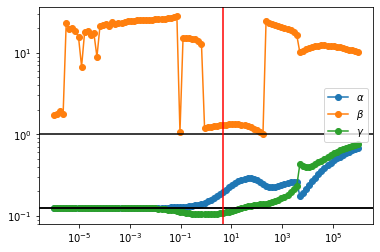

In [16]:
idx = 55
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\gamma$')
for q in p0:
    plt.axhline(q, color='k')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()

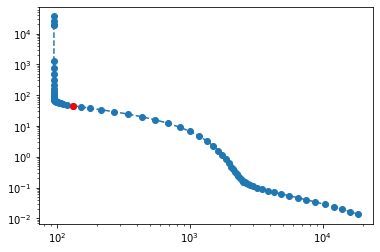

In [17]:
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

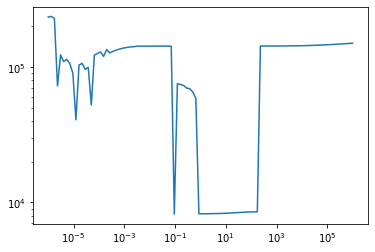

In [18]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])

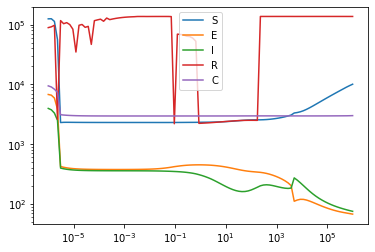

In [19]:
getM = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]), axis=0)
plt.semilogx(prange, [getM(i) for i,_ in enumerate(prange)])
plt.yscale('log')
plt.legend("SEIRC")

In [20]:
# applying the final size relation
from scipy.optimize import brentq
def rinf(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    r0 = pfin[1]/pfin[0]
    S0, E0, I0, R0, C0 = [float(x[0]) for x in getx(sol['x'])]
    N = sum((S0, E0, I0, R0))
    f = lambda y: y/S0 - np.exp(r0*(y-N)/N) 
    sinf = brentq(f, 0, S0) 
    return N-sinf

# def rinf(sol):
#     r0 = 8*getp(sol['x'])
#     S0, E0, I0, R0 = [float(x[0]) for x in getx(sol['x'])]
#     N = sum((S0, E0, I0, R0))
#     f = lambda y: y/S0 - np.exp(r0*(y-N)/N)
#     sinf = brentq(f, 0, S0)
#     return N-sinf

(0, 20000)

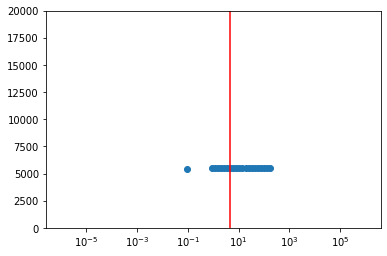

In [21]:
plt.semilogx(prange[:], [rinf(sol) for sol in sols][:], 'o')
plt.axvline(prange[idx], color='r')
plt.ylim([0,20000])

In [22]:
rinf(sols[idx])

5536.025652517449

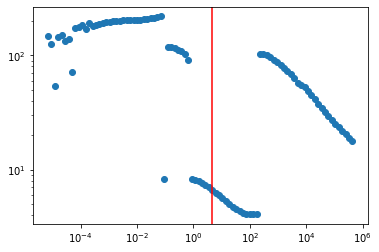

In [23]:
def r0(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    return pfin[1]/pfin[0]
# def r0(sol):
#     return 8*getp(sol['x'])
plt.plot(prange[7:-3], [r0(sol) for sol in sols][7:-3], 'o')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')

In [24]:
[getx(sols[idx]['x'])[i][50] for i in range(5)]

[DM(655.765), DM(1968.13), DM(954.305), DM(1684.94), DM(3147.66)]

In [25]:
getx(sols[idx]['x'])[0][0]

DM(5512.73)

In [26]:
getp(sols[idx]['x'])

(DM(0.195679), DM(1.30265), DM(0.109388))

In [27]:
r0(sols[idx])

6.657091259955998

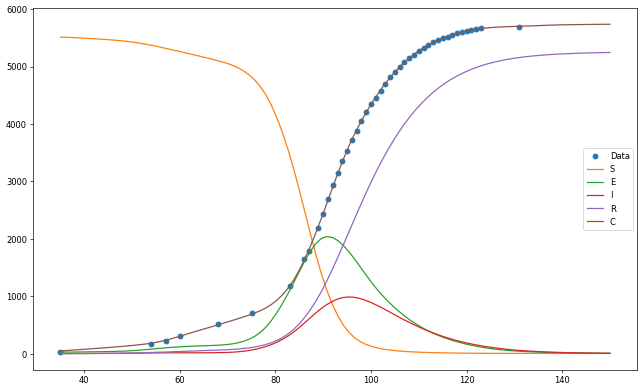

In [28]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[0], label='S')
ax.plot(model.observation_times, getx(sols[idx]['x'])[1], label='E')
ax.plot(model.observation_times, getx(sols[idx]['x'])[2], label='I')
ax.plot(model.observation_times, getx(sols[idx]['x'])[3], label='R')
ax.plot(model.observation_times, getx(sols[idx]['x'])[4], label='C')
plt.legend()

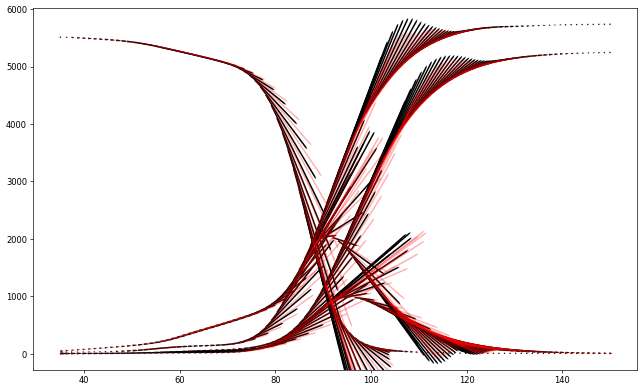

In [29]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
xx = np.vstack([xix.toarray().flatten() for xix in getx(sols[idx]['x'])])
dxxdt = np.vstack([seir(0, xxj, [float(q) for q in getp(sols[idx]['x'])]) for xxj in xx.T])
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, [1]*len(model.observation_times), dxxdt[:,i], 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025)
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), np.gradient(xxi, model.observation_times), color='r', 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.3)

Text(0.5, 1.0, 'Number of Reported Cases (Prediction)')

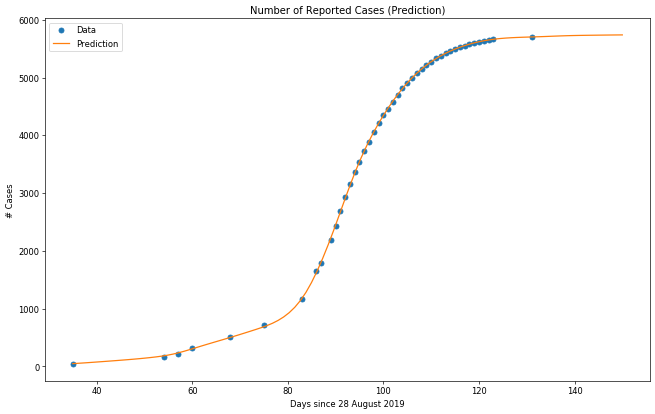

In [30]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)

ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[4], label='Prediction')
plt.legend()
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Prediction)")

(0, 10000)

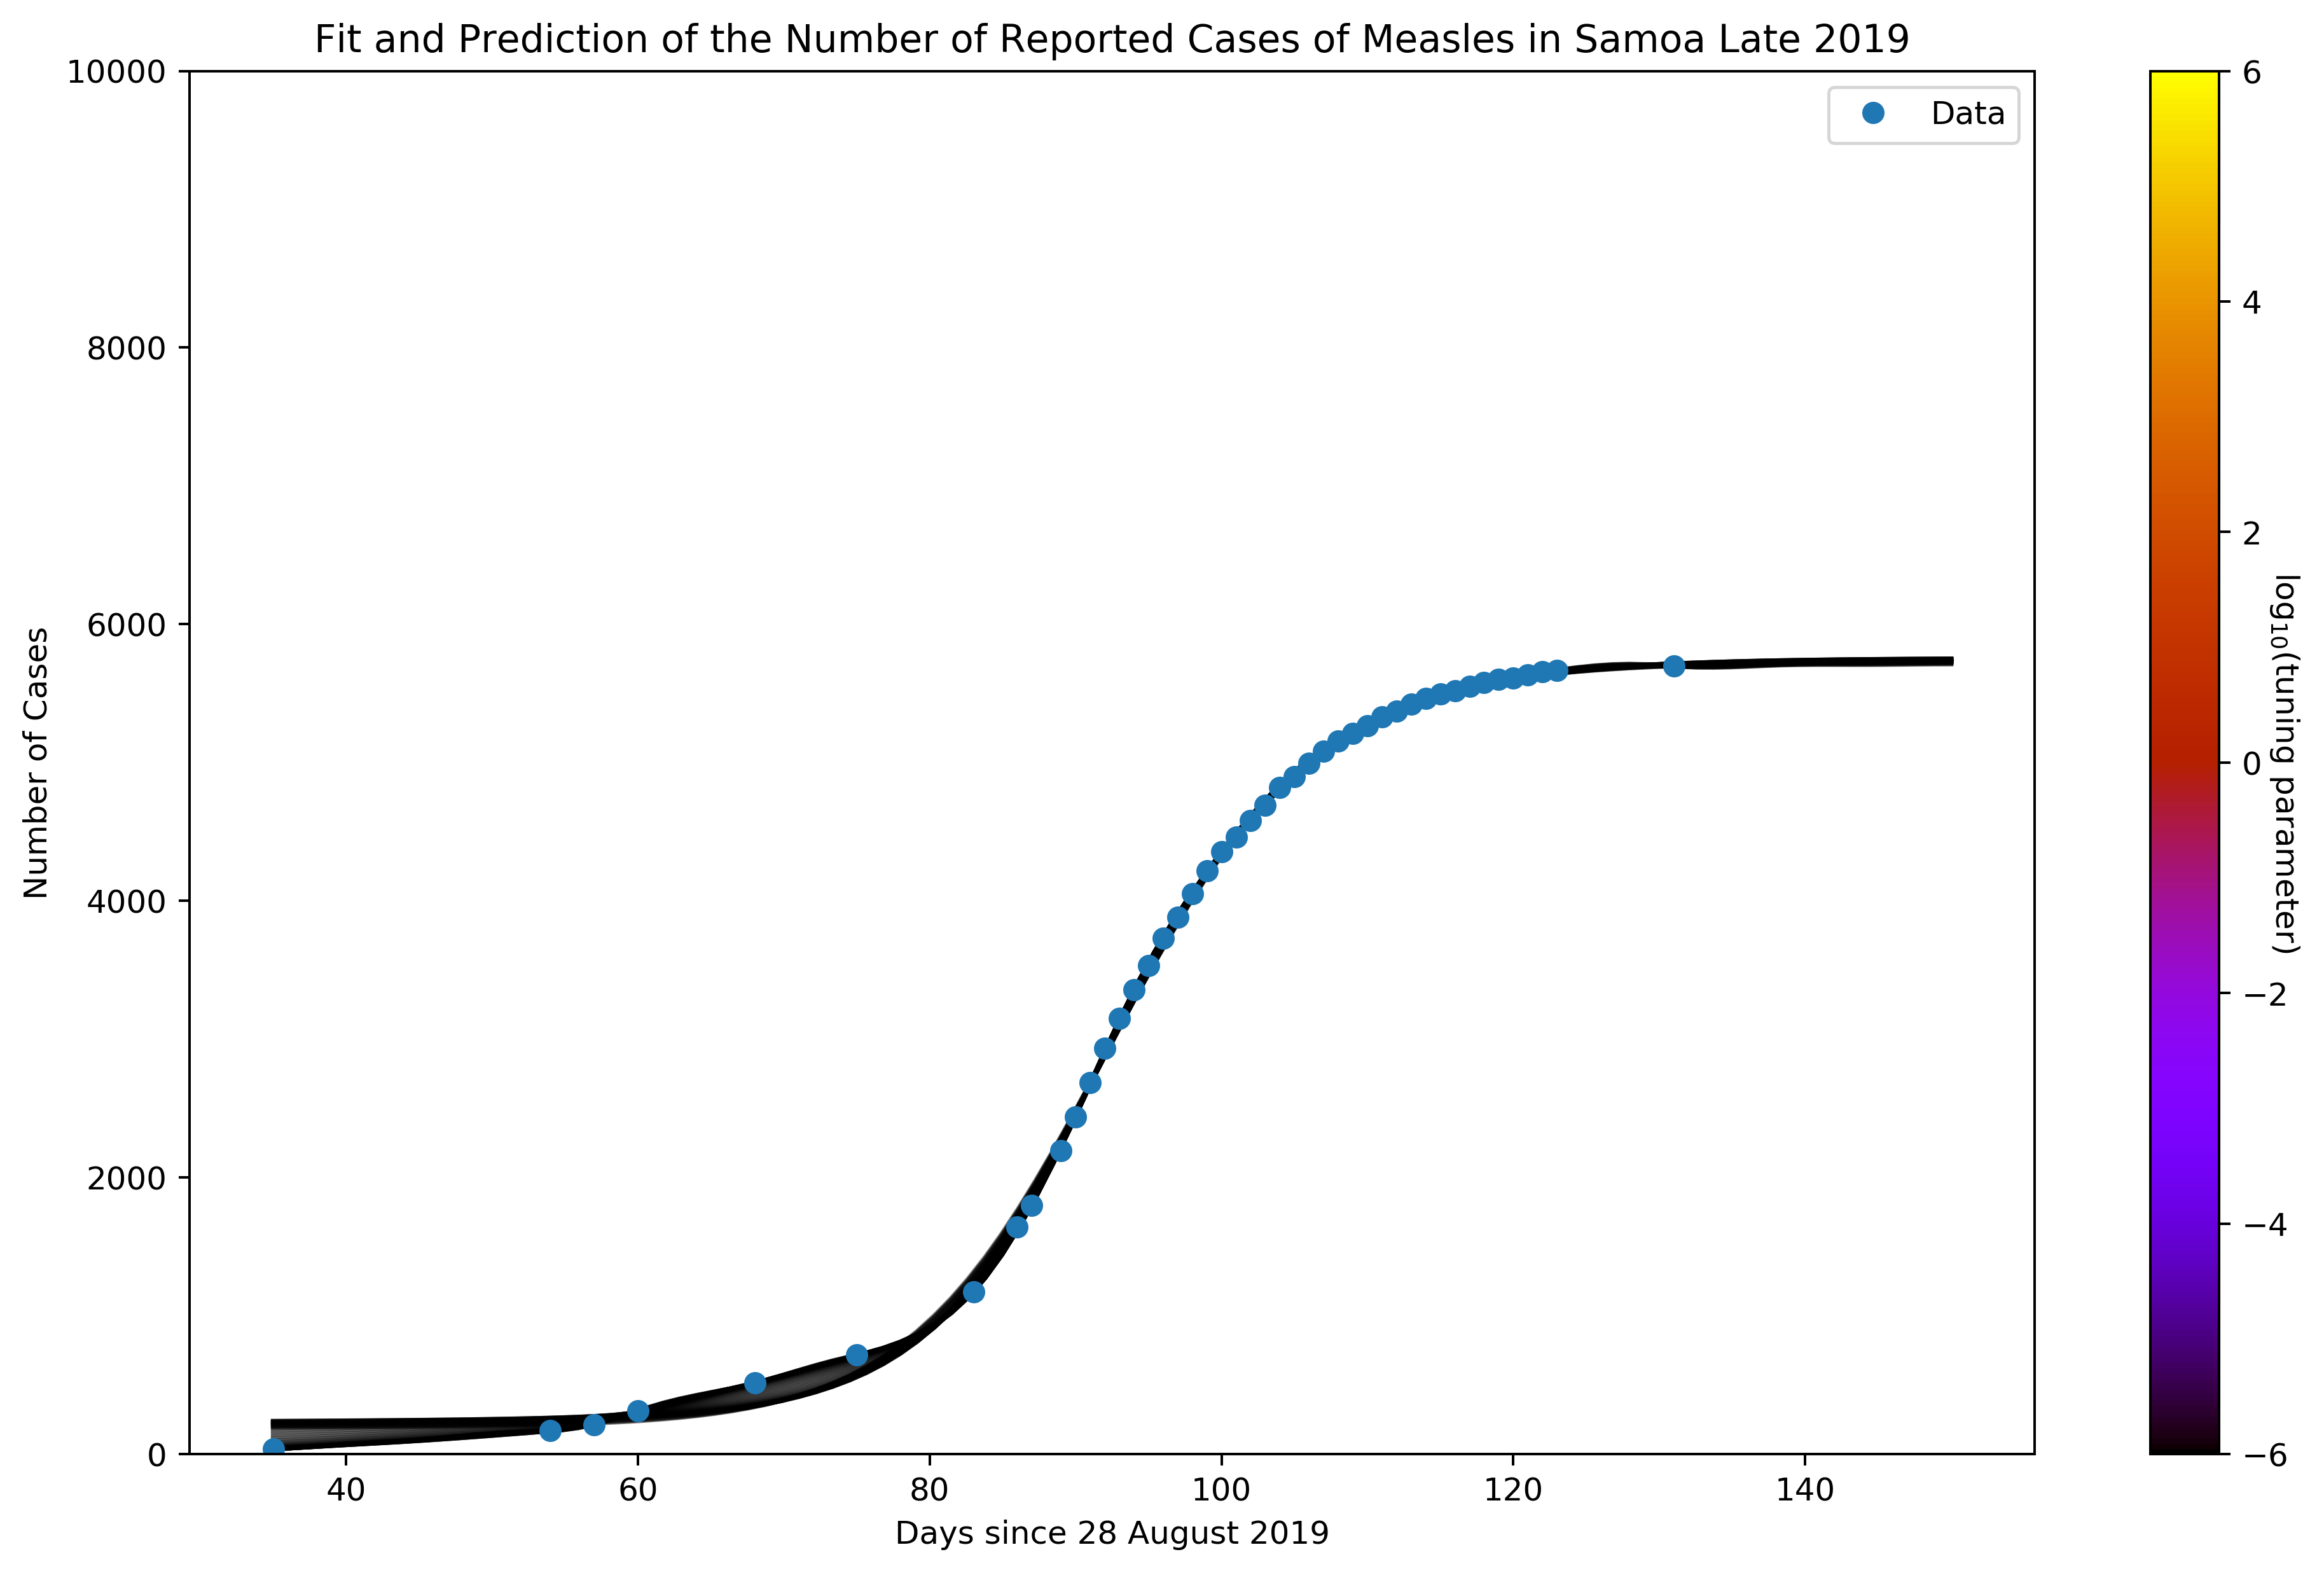

In [31]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors

plt.figure(figsize=[13,8], dpi=360)

cNorm = colors.Normalize(vmin=np.log10(prange[0]), vmax=np.log10(prange[-1]))
cm = plt.get_cmap('gnuplot')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

for i,p in enumerate(prange[40:-15:]):
    plt.plot(model.observation_times, getx(sols[i+40]['x'])[-1], color='k', alpha=0.4)
plt.plot(times, cumdata, 'o', label="Data")
plt.title("Fit and Prediction of the Number of Reported Cases of Measles in Samoa Late 2019")
plt.xlabel("Days since 28 August 2019")
plt.ylabel("Number of Cases")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()
plt.ylim(0, 10000)

In [32]:
fsvals[idx]

array([131.89050466,  45.64915788])

In [33]:
# getc = ca.Function('getx', [solver_setup['x']], model.cs)
# np.sqrt(ca.sumsqr(cumdata - objective.collocation_matrices[0]@getc(sols[idx]['x'])[-1])/(len(times)-1))

In [34]:
getp(sols[idx]['x'])

(DM(0.195679), DM(1.30265), DM(0.109388))

In [35]:
profiler_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),

}
opts = {'ipopt': {'dual_inf_tol': 1e-1, 'print_frequency_iter': 10}}
profiler = ca.nlpsol('solver', 'ipopt', profiler_setup, opts)

In [36]:
rho = prange[idx]
pref = getp(sols[idx]['x'])
lbx = [-np.inf]*(config['basis_number']*config['model_form']['state']) + [0]*config['model_form']['parameters']
ubx = [np.inf]*(config['basis_number']*config['model_form']['state'] + config['model_form']['parameters'])

profiles = []
for pdx in range(config['model_form']['parameters']):
    pdx_mod = config['basis_number']*config['model_form']['state'] + pdx
    pvals = np.logspace(-1.5, 0.5, num=50)
    profiles.append([])
    for pval in pvals:
        lbx0 = np.array(lbx)
        ubx0 = np.array(ubx)
        lbx0[pdx_mod] = pval
        ubx0[pdx_mod] = pval
        profiles[pdx].append(profiler(x0=np.array(sols[idx]['x']).flatten(), p=[rho, alpha], 
                                      lbx=lbx0, ubx=ubx0, lbg=lbg, ubg=ubg))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1761

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  


Number of Iterations....: 56

                                   (scaled)                 (unscaled)
Objective...............:   9.9741395041948011e-02    3.7311236094560752e+02
Dual infeasibility......:   2.0178704060065723e-10    7.5484445645736314e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    9.3740777644127227e-06
Overall NLP error.......:   2.5059035596800626e-09    9.3740777644127227e-06


Number of objective function evaluations             = 68
Number of objective gradient evaluations             = 57
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 68
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 57
Number of Lagrangian Hessian evaluations             = 56
Total CPU secs in IPOPT (w/o function evaluations)   =      0.098
Total CPU secs in NLP function evaluation

  50  6.4878740e+02 0.00e+00 4.99e-02  -3.8 2.52e+02  -8.1 1.00e+00 1.00e+00f  1
  60  4.8366464e+02 0.00e+00 8.81e-01  -3.8 8.15e+03    -  8.67e-01 6.12e-02f  4
  70  4.2460217e+02 0.00e+00 2.01e+00  -3.8 7.14e+02 -11.1 1.00e+00 2.50e-01f  3
  80  3.8609596e+02 0.00e+00 9.64e-07  -3.8 8.91e+01    -  1.00e+00 1.00e+00h  1
  90  3.6806278e+02 0.00e+00 2.91e-06  -8.6 1.03e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 92

                                   (scaled)                 (unscaled)
Objective...............:   1.0935452730545034e-01    3.6806264186051550e+02
Dual infeasibility......:   6.3703225001082800e-09    2.1441066837078966e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5495169948646671e-09    8.5810984119301465e-06
Overall NLP error.......:   6.3703225001082800e-09    2.1441066837078966e-05


Number of objective funct

  30  1.3552004e+04 0.00e+00 1.11e+02  -3.8 1.30e+03  -9.8 1.00e+00 1.00e+00f  1
  40  1.0965422e+04 0.00e+00 3.05e+00  -3.8 3.17e+03 -10.1 1.00e+00 1.00e+00f  1
  50  4.8350565e+03 0.00e+00 2.47e+00  -3.8 5.35e+02  -9.4 1.00e+00 1.00e+00f  1
  60  3.6641033e+03 0.00e+00 9.50e-04  -3.8 4.79e+01  -7.9 1.00e+00 1.00e+00f  1
  70  2.6124725e+03 0.00e+00 3.27e-01  -5.7 4.03e+01  -7.2 1.00e+00 1.00e+00f  1
  80  9.9928818e+02 0.00e+00 1.51e+00  -5.7 1.26e+03  -9.3 3.03e-01 5.09e-01f  1
  90  4.7182814e+02 0.00e+00 1.96e-01  -5.7 2.40e+02  -9.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.5407912e+02 0.00e+00 2.01e-01  -5.7 3.95e+03    -  1.00e+00 2.50e-01f  3
 110  4.2209109e+02 0.00e+00 1.60e+00  -5.7 3.74e+03 -12.1 1.00e+00 1.74e-01f  3
 120  3.6271331e+02 0.00e+00 1.98e-01  -5.7 7.35e+01  -9.2 1.00e+00 1.00e+00f  1
 130  3.6237712e+02 0.00e+00 7.82e-05  -8.6 6.63e-01 -12.1 6.89e-01 9.09e-01f  1
 140  3.6236762e+02 0.00e+00

  20  2.0188470e+03 0.00e+00 1.57e+01  -3.8 3.61e+02  -7.4 1.00e+00 5.00e-01f  2
  30  4.0825686e+02 0.00e+00 1.20e+00  -3.8 2.44e+03    -  8.20e-01 1.00e+00f  1
  40  3.6349306e+02 0.00e+00 4.79e-02  -3.8 4.51e+02 -10.9 1.00e+00 1.00e+00f  1
  50  3.5462829e+02 0.00e+00 1.43e-06  -5.7 1.60e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 58

                                   (scaled)                 (unscaled)
Objective...............:   1.8227605235900352e-01    3.5455198324351119e+02
Dual infeasibility......:   1.8567520524323230e-09    3.6116380295791639e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0435929321078613e-09    2.0299317380925087e-06
Overall NLP error.......:   1.8567520524323230e-09    3.6116380295791639e-06


Number of objective function evaluations             = 106
Number of objective gradient evaluations             = 59
Number of equality constraint evaluations            = 0
Number of ine


Number of Iterations....: 85

                                   (scaled)                 (unscaled)
Objective...............:   3.5470493851589002e-01    3.4947207507608067e+02
Dual infeasibility......:   2.5732010846628957e-09    2.5352393637588971e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8477293129610978e-09    2.8057175533543170e-06
Overall NLP error.......:   2.8477293129610978e-09    2.8057175533543170e-06


Number of objective function evaluations             = 126
Number of objective gradient evaluations             = 86
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 126
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 86
Number of Lagrangian Hessian evaluations             = 85
Total CPU secs in IPOPT (w/o function evaluations)   =      0.159
Total CPU secs in NLP function evaluati

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1761

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.3248411e+02 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.

  40  4.6879115e+02 0.00e+00 1.35e-02  -3.8 7.65e+01  -7.7 1.00e+00 1.00e+00f  1
  50  3.9913523e+02 0.00e+00 5.38e-01  -3.8 1.90e+04    -  1.00e+00 1.00e+00f  1
  60  3.9218004e+02 0.00e+00 5.45e-01  -3.8 8.02e+03    -  1.00e+00 5.00e-01f  2
  70  3.6763007e+02 0.00e+00 1.34e+00  -3.8 7.94e+02    -  1.00e+00 1.00e+00f  1
  80  3.5585493e+02 0.00e+00 1.67e-06  -3.8 1.24e+01    -  1.00e+00 1.00e+00h  1
  90  3.5148809e+02 0.00e+00 1.09e-06  -8.6 7.87e+02 -14.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.5140276e+02 0.00e+00 4.68e-02  -8.6 1.23e+03 -13.4 1.00e+00 1.00e+00h  1
 110  3.5127052e+02 0.00e+00 5.75e-02  -8.6 8.48e+02 -12.8 1.00e+00 1.00e+00h  1
 120  3.5106892e+02 0.00e+00 3.36e-02  -8.6 7.90e+02 -12.1 1.00e+00 5.00e-01f  2
 130  3.5076877e+02 0.00e+00 4.73e-05  -8.6 1.52e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 132

                                   (scaled)                 (unscaled)
Object

  30  4.1689273e+02 0.00e+00 6.86e-01  -3.8 3.62e+03    -  8.01e-01 1.00e+00f  1
  40  4.0285415e+02 0.00e+00 4.19e-02  -3.8 1.78e+02  -9.6 1.00e+00 2.50e-01f  3
  50  3.9165360e+02 0.00e+00 2.79e-02  -3.8 5.81e+02    -  1.00e+00 1.00e+00f  1
  60  3.6704875e+02 0.00e+00 1.83e-01  -5.7 1.76e+05    -  3.45e-01 4.80e-02f  4
  70  3.6624326e+02 0.00e+00 1.12e-06  -9.0 2.87e+02 -14.1 1.00e+00 1.00e+00h  1
  80  3.6615782e+02 0.00e+00 3.00e-02  -9.0 2.98e+01  -9.8 1.00e+00 1.00e+00f  1

Number of Iterations....: 84

                                   (scaled)                 (unscaled)
Objective...............:   1.0787380546554941e-01    3.6615061501165320e+02
Dual infeasibility......:   8.6558554074945079e-09    2.9380133269871721e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    3.0856814036419887e-06
Overall NLP error.......:   8.6558554074945079e-09    2.9380133269871721e-05


Number of objective funct

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1761

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1549517e+05 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.

  90  4.9097206e+02 0.00e+00 1.92e-01  -5.7 1.22e+02 -10.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.8441405e+02 0.00e+00 1.18e-01  -5.7 3.67e+03 -13.7 1.00e+00 5.00e-01f  2
 110  4.8383352e+02 0.00e+00 1.49e-06  -8.6 5.96e+02 -14.7 1.00e+00 1.00e+00h  1
 120  4.8362139e+02 0.00e+00 1.28e-02  -8.6 3.75e+02 -13.2 1.00e+00 1.00e+00h  1
 130  4.8351188e+02 0.00e+00 3.18e-08  -8.6 9.36e+00 -11.6 1.00e+00 1.00e+00h  1
 140  4.8312218e+02 0.00e+00 2.74e-02  -8.6 5.89e+02 -12.8 1.00e+00 1.00e+00h  1
 150  4.8255721e+02 0.00e+00 2.28e-02  -8.6 8.68e+01    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 154

                                   (scaled)                 (unscaled)
Objective...............:   4.9893498184037419e-02    4.8253596357767879e+02
Dual infeasibility......:   8.9711153374536927e-09    8.6762522999633327e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

  40  1.5443280e+04 0.00e+00 4.29e+00  -2.5 1.93e+02  -9.1 1.00e+00 1.00e+00f  1
  50  1.5613957e+04 0.00e+00 6.85e-01  -2.5 3.74e+01  -9.3 1.00e+00 1.00e+00f  1
  60  1.5025908e+04 0.00e+00 1.82e+00  -3.8 1.70e+02  -9.9 1.00e+00 1.00e+00f  1
  70  1.4850046e+04 0.00e+00 1.33e+01  -3.8 9.66e+02 -11.0 1.00e+00 1.00e+00f  1
  80  1.4649854e+04 0.00e+00 4.29e+01  -3.8 2.47e+04 -12.2 7.73e-01 5.76e-02f  3
  90  1.4477815e+04 0.00e+00 2.24e+01  -3.8 9.64e+02 -10.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.4218006e+04 0.00e+00 7.54e+01  -3.8 1.81e+03 -10.9 1.00e+00 1.00e+00f  1
 110  1.4044421e+04 0.00e+00 1.93e+01  -3.8 7.32e+02 -10.2 1.00e+00 1.00e+00f  1
 120  1.3776050e+04 0.00e+00 2.53e+00  -3.8 2.31e+02  -9.6 1.00e+00 1.00e+00f  1
 130  1.3499695e+04 0.00e+00 1.30e+01  -3.8 5.05e+02  -9.8 1.00e+00 1.00e+00f  1
 140  1.3072393e+04 0.00e+00 1.88e-01  -3.8 4.38e+01  -8.3 1.00e+00 1.00e+00f  1
 150  1.2721471e+04 0.00e+00

 270  1.1169478e+04 0.00e+00 8.76e-03  -5.7 6.57e-01  -7.5 1.00e+00 1.00e+00f  1
 280  1.1130093e+04 0.00e+00 1.55e-01  -5.7 4.68e+01  -9.5 1.00e+00 1.00e+00f  1
 290  1.1061830e+04 0.00e+00 4.61e+00  -5.7 3.65e+02  -9.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.0973672e+04 0.00e+00 4.29e-01  -5.7 2.37e+01  -8.2 1.00e+00 1.00e+00f  1
 310  1.0886781e+04 0.00e+00 1.03e-01  -5.7 9.08e+01  -9.4 1.00e+00 1.00e+00f  1
 320  1.0772726e+04 0.00e+00 1.85e-01  -5.7 9.78e+01  -9.7 1.00e+00 1.00e+00f  1
 330  1.0621230e+04 0.00e+00 2.42e-03  -5.7 2.72e+01  -9.0 1.00e+00 1.00e+00f  1
 340  1.0435024e+04 0.00e+00 1.02e+00  -5.7 4.70e+02 -10.2 1.00e+00 1.00e+00f  1
 350  1.0177458e+04 0.00e+00 1.26e-01  -5.7 1.49e+02  -9.5 1.00e+00 1.00e+00f  1
 360  9.7524297e+03 0.00e+00 7.07e-02  -5.7 5.40e+01  -8.9 1.00e+00 1.00e+00f  1
 370  9.0373392e+03 0.00e+00 1.55e-02  -5.7 4.56e+01  -8.2 9.02e-01 1.00e+00f  1
 380  7.9686837e+03 0.00e+00

  60  1.2216079e+03 0.00e+00 2.96e-02  -5.7 7.24e+03 -12.7 1.00e+00 1.00e+00f  1
  70  1.1499562e+03 0.00e+00 1.16e-02  -8.6 9.94e+02 -11.2 1.00e+00 1.00e+00f  1
  80  1.0522090e+03 0.00e+00 1.22e-01  -8.6 2.24e+03 -11.4 1.00e+00 1.00e+00f  1
  90  9.1398321e+02 0.00e+00 7.13e-02  -8.6 7.90e+02 -11.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.2209649e+02 0.00e+00 1.13e-02  -8.6 1.13e+05    -  8.91e-01 3.73e-02f  4
 110  8.1643191e+02 0.00e+00 1.48e-03  -8.6 2.26e+04    -  1.00e+00 5.00e-01h  2
 120  8.1633985e+02 0.00e+00 6.98e-09  -8.6 1.55e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 120

                                   (scaled)                 (unscaled)
Objective...............:   4.4348530825696883e-02    8.1633985474854603e+02
Dual infeasibility......:   6.9825976239507875e-09    1.2853126414732720e-04
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

  40  5.4440551e+03 0.00e+00 2.73e+00  -3.8 3.82e+02  -9.6 1.00e+00 1.00e+00f  1
  50  1.5457581e+03 0.00e+00 1.28e-01  -3.8 3.57e+02 -10.8 1.00e+00 1.00e+00f  1
  60  1.6284041e+03 0.00e+00 1.72e-01  -5.7 2.76e+04    -  3.44e-01 8.84e-02f  3
  70  1.3693600e+03 0.00e+00 3.54e-02  -5.7 1.07e+03 -11.1 1.00e+00 1.00e+00f  1
  80  1.2663829e+03 0.00e+00 8.02e-02  -5.7 1.37e+02 -11.8 1.00e+00 1.00e+00f  1
  90  1.2635408e+03 0.00e+00 1.62e-07  -8.6 5.50e+00 -14.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 94

                                   (scaled)                 (unscaled)
Objective...............:   4.8604485345902858e-02    1.2635369954953135e+03
Dual infeasibility......:   2.3999385147187296e-09    6.2389532132281031e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    6.5144231695193994e-05
Overall NLP error......

 210  1.2355174e+04 0.00e+00 4.60e-02  -5.7 4.91e+02 -11.1 1.00e+00 1.00e+00f  1
 220  1.2289290e+04 0.00e+00 7.42e-03  -5.7 2.36e+01  -9.6 1.00e+00 1.00e+00h  1
 230  1.2209917e+04 0.00e+00 4.75e-03  -5.7 5.73e-01  -6.0 1.00e+00 1.00e+00h  1
 240  1.2187536e+04 0.00e+00 1.70e+00  -5.7 8.36e+02 -10.8 1.00e+00 1.00e+00f  1
 250  1.2081304e+04 0.00e+00 1.63e-01  -5.7 2.05e+01  -8.3 1.00e+00 1.00e+00h  1
 260  1.1966097e+04 0.00e+00 4.75e+00  -5.7 1.83e+03 -11.3 1.00e+00 1.00e+00f  1
 270  1.1907387e+04 0.00e+00 9.15e-03  -5.7 4.90e+01  -9.8 1.00e+00 1.00e+00f  1
 280  1.1754238e+04 0.00e+00 1.41e+00  -5.7 8.96e+02 -10.9 1.00e+00 1.00e+00f  1
 290  1.1563443e+04 0.00e+00 1.58e-03  -5.7 3.51e+01  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.1286265e+04 0.00e+00 1.05e+00  -5.7 6.88e+02 -10.5 1.00e+00 1.00e+00f  1
 310  1.0818220e+04 0.00e+00 2.34e-03  -5.7 3.27e+01  -9.0 1.00e+00 1.00e+00f  1
 320  1.0028016e+04 0.00e+00

  80  1.6537601e+04 0.00e+00 1.05e+01  -3.8 9.35e+02 -11.1 1.00e+00 1.00e+00f  1
  90  1.6216450e+04 0.00e+00 5.72e+00  -3.8 1.82e+03 -10.9 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.5889240e+04 0.00e+00 7.98e+00  -3.8 1.56e+03 -11.1 8.72e-01 5.00e-01f  2
 110  1.5517128e+04 0.00e+00 2.17e+00  -3.8 2.75e+02 -10.4 1.00e+00 1.00e+00f  1
 120  1.5191701e+04 0.00e+00 1.81e+01  -3.8 7.29e+03    -  1.00e+00 2.50e-01f  3
 130  1.4898713e+04 0.00e+00 3.74e+00  -3.8 1.61e+03 -11.2 1.00e+00 2.50e-01f  3
 140  1.4736064e+04 0.00e+00 9.42e-01  -3.8 3.36e+02    -  1.00e+00 1.00e+00h  1
 150  1.4357194e+04 0.00e+00 5.29e-01  -5.7 3.34e+01  -8.4 1.00e+00 1.00e+00f  1
 160  1.4132261e+04 0.00e+00 5.80e+00  -5.7 1.31e+02  -9.5 1.00e+00 1.00e+00f  1
 170  1.3995835e+04 0.00e+00 3.04e-01  -5.7 1.53e+02  -9.8 1.00e+00 1.00e+00f  1
 180  1.3901103e+04 0.00e+00 3.67e-01  -5.7 8.49e+02 -10.9 1.00e+00 1.00e+00f  1
 190  1.3847949e+04 0.00e+00

  50  1.8578821e+04 0.00e+00 1.21e+01  -3.8 1.59e+04    -  1.00e+00 1.25e-01f  4
  60  1.8300067e+04 0.00e+00 1.26e+01  -3.8 6.21e+03    -  1.00e+00 5.00e-01f  2
  70  1.7962725e+04 0.00e+00 4.55e-01  -3.8 3.35e+01  -9.2 1.00e+00 1.00e+00f  1
  80  1.7630178e+04 0.00e+00 7.65e+00  -3.8 8.03e+02  -9.9 1.00e+00 5.00e-01f  2
  90  1.7231827e+04 0.00e+00 7.55e+00  -3.8 5.70e+03 -11.4 1.00e+00 1.51e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.6891792e+04 0.00e+00 9.50e-01  -3.8 2.60e+02 -10.7 1.00e+00 1.00e+00f  1
 110  1.6601589e+04 0.00e+00 1.85e+00  -3.8 7.03e+02    -  1.00e+00 1.00e+00f  1
 120  1.6360990e+04 0.00e+00 1.83e+01  -5.7 2.22e+04    -  5.59e-01 5.53e-02f  3
 130  1.5963825e+04 0.00e+00 7.55e+00  -5.7 1.25e+03 -10.3 1.00e+00 5.00e-01f  2
 140  1.5717980e+04 0.00e+00 5.29e-01  -5.7 1.09e+02  -9.6 1.00e+00 1.00e+00f  1
 150  1.5485646e+04 0.00e+00 4.32e+00  -5.7 9.76e+02 -10.8 1.00e+00 1.00e+00f  1
 160  1.5345227e+04 0.00e+00

 380  1.2829710e+04 0.00e+00 5.43e+00  -8.6 3.97e+04 -12.0 6.06e-04 2.41e-02f  1
 390  1.1581185e+04 0.00e+00 2.10e+00  -8.6 4.83e+02  -9.6 8.07e-02 3.19e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.1129586e+04 0.00e+00 1.17e-01  -8.6 3.68e+03  -9.8 1.04e-02 1.72e-02f  1
 410  9.7779899e+03 0.00e+00 1.76e+00  -8.6 5.91e+03 -10.1 9.50e-03 1.50e-01f  1
 420  7.9054869e+03 0.00e+00 4.34e+00  -8.6 5.91e+02  -8.5 4.65e-03 1.22e-02f  1
 430  6.2230797e+03 0.00e+00 8.45e-01  -8.6 1.53e+03 -12.4 4.60e-02 6.86e-02f  1
 440  6.0610648e+03 0.00e+00 6.94e-01  -8.6 3.89e+04 -13.5 2.63e-03 5.58e-03f  1
 450  5.6967670e+03 0.00e+00 6.62e-01  -8.6 1.08e+04 -14.7 9.21e-02 3.91e-02f  1
 460  5.6225182e+03 0.00e+00 5.29e-01  -8.6 1.52e+05 -15.9 5.99e-03 1.57e-02f  1
 470  5.4047289e+03 0.00e+00 3.65e-01  -8.6 1.34e+02  -8.9 6.70e-04 2.94e-02f  1
 480  5.3220573e+03 0.00e+00 1.20e-01  -8.6 1.26e+03 -13.7 2.78e-04 9.49e-02f  1
 490  5.3060543e+03 0.00e+00

 530  6.2555472e+03 0.00e+00 2.66e-06  -8.6 2.92e+00 -11.3 1.00e+00 1.00e+00h  1

Number of Iterations....: 535

                                   (scaled)                 (unscaled)
Objective...............:   9.3259742890529157e-02    6.2555390487904569e+03
Dual infeasibility......:   4.2467420566105781e-09    2.8485668029828970e-04
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   5.2519141613143855e-10    3.5228012750970292e-05
Overall NLP error.......:   4.2467420566105781e-09    2.8485668029828970e-04


Number of objective function evaluations             = 769
Number of objective gradient evaluations             = 536
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 769
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 536
Number of Lagrangian Hessian evaluations             = 535
Total CPU secs in IP

  10  2.2765241e+04 0.00e+00 1.65e-01  -1.0 7.32e-01  -4.0 1.00e+00 1.00e+00f  1
  20  1.2319579e+04 0.00e+00 4.36e-03  -5.7 4.96e+01  -7.3 7.04e-02 9.93e-01f  1
  30  1.1440300e+04 0.00e+00 3.17e+01  -5.7 6.45e+03 -10.3 3.41e-01 1.79e-01f  3
  40  7.7442414e+03 0.00e+00 1.51e+01  -5.7 4.05e+02    -  1.00e+00 4.84e-01f  1
  50  6.5160337e+03 0.00e+00 1.92e-01  -5.7 1.00e+01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 59

                                   (scaled)                 (unscaled)
Objective...............:   1.2153456924760226e+00    6.5101008240547044e+03
Dual infeasibility......:   7.1067596252305520e-11    3.8067952171134955e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   7.2213296743036920e-09    3.8681656218880821e-05
Overall NLP error.......:   7.2213296743036920e-09    3.8681656218880821e-05


Number of objective function evaluations             = 69
Number of objective gradient evaluations        

  30  1.2573063e+04 0.00e+00 4.75e+00  -5.7 1.26e+03  -9.9 1.28e-01 1.27e-02f  1
  40  1.1982335e+04 0.00e+00 5.94e+01  -5.7 2.97e+03 -10.1 1.00e+00 5.00e-01f  2
  50  8.4618402e+03 0.00e+00 1.64e+01  -5.7 1.50e+03  -9.5 2.81e-01 1.01e-01f  2
  60  5.2530684e+03 0.00e+00 6.49e+00  -5.7 4.11e+03  -9.7 6.82e-01 3.06e-01f  1
  70  5.0649847e+03 0.00e+00 1.50e-06  -5.7 1.75e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 75

                                   (scaled)                 (unscaled)
Objective...............:   9.5750140606942458e-01    5.0648078618615664e+03
Dual infeasibility......:   3.9191760947687726e-10    2.0730908352698079e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7570224439002449e-09    1.4583570176169841e-05
Overall NLP error.......:   2.7570224439002449e-09    1.4583570176169841e-05


Number of objective function evaluations             = 112
Number of objective gradient evaluations       

  30  1.2238024e+04 0.00e+00 2.14e+00  -3.8 1.64e+02  -9.0 1.00e+00 1.00e+00f  1
  40  9.4010713e+03 0.00e+00 1.25e+01  -3.8 6.61e+02  -9.2 1.00e+00 1.00e+00f  1
  50  3.8086841e+03 0.00e+00 6.08e+00  -3.8 6.85e+01    -  1.00e+00 1.00e+00f  1
  60  3.3532286e+03 0.00e+00 4.41e-08  -3.8 9.30e-03    -  1.00e+00 1.00e+00h  1
  70  3.2844142e+03 0.00e+00 1.19e-03  -8.6 1.35e-01    -  8.91e-01 1.00e+00h  1

Number of Iterations....: 71

                                   (scaled)                 (unscaled)
Objective...............:   6.3258278274519386e-01    3.2844141674908274e+03
Dual infeasibility......:   7.5879924565924739e-10    3.9397388937922681e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.8208957447919333e-09    1.9838358644919012e-05
Overall NLP error.......:   3.8208957447919333e-09    1.9838358644919012e-05


Number of objective function evaluations             = 96
Number of objective gradient evaluations        

  60  2.6047586e+03 0.00e+00 1.04e+01  -5.7 1.04e+02    -  1.92e-01 1.00e+00f  1
  70  2.0520014e+03 0.00e+00 1.92e-02  -5.7 2.32e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 76

                                   (scaled)                 (unscaled)
Objective...............:   4.0304094432699494e-01    2.0517540924442496e+03
Dual infeasibility......:   4.2967229774149018e-10    2.1873258975539274e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.6286956336843093e-09    2.3563226870036200e-05
Overall NLP error.......:   4.6286956336843093e-09    2.3563226870036200e-05


Number of objective function evaluations             = 101
Number of objective gradient evaluations             = 77
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 101
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 77
N

                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.2579980e+04 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  2.2408741e+04 0.00e+00 8.50e-01  -1.0 1.96e+00  -4.0 1.00e+00 1.00e+00f  1
  20  1.3137217e+04 0.00e+00 3.93e-03  -5.7 6.37e+01  -6.9 1.00e+00 6.37e-01f  1
  30  1.2506339e+04 0.00e+00 5.38e+01  -5.7 1.59e+03  -9.8 1.00e+00 1.00e+00f  1
  40  1.0081822e+04 0.00e+00 8.44e+01  -5.7 2.35e+03 -10.1 7.30e-01 1.00e+00f  1
  50  3.7410653e+03 0.00e+00 1.92e+01  -5.7 2.48e+05 -11.2 5.70e-05 7.47e-04f  1
  60  2.0920547e+03 0.00e+00 8.75e+00  -5.7 1.42

  40  6.9697989e+02 0.00e+00 5.65e+00  -5.7 2.69e+02    -  6.50e-01 9.17e-01f  1
  50  5.9285830e+02 0.00e+00 1.19e-07  -5.7 4.99e-01    -  1.00e+00 1.00e+00h  1
  60  5.9232583e+02 0.00e+00 1.65e-08  -9.0 2.97e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 61

                                   (scaled)                 (unscaled)
Objective...............:   1.2798438598627065e-01    5.9232583305923572e+02
Dual infeasibility......:   6.5490021660086591e-14    3.0309503255373258e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.1030702847729371e-10    4.2130011784432210e-06
Overall NLP error.......:   9.1030702847729371e-10    4.2130011784432210e-06


Number of objective function evaluations             = 77
Number of objective gradient evaluations             = 62
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 77
Number of equality constraint Jacobia

  40  5.6263541e+02 0.00e+00 5.36e-02  -3.8 4.13e+01  -9.4 1.00e+00 1.00e+00f  1
  50  5.5155936e+02 0.00e+00 1.00e-03  -3.8 3.78e+00    -  1.00e+00 1.00e+00h  1
  60  5.0026314e+02 0.00e+00 8.93e-04  -5.7 4.19e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 67

                                   (scaled)                 (unscaled)
Objective...............:   1.1827606378513777e-01    5.0015370040659747e+02
Dual infeasibility......:   7.1314629108729746e-10    3.0156799694189013e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0243682694960659e-09    4.3317435850612011e-06
Overall NLP error.......:   1.0243682694960659e-09    4.3317435850612011e-06


Number of objective function evaluations             = 102
Number of objective gradient evaluations             = 68
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 102
Number of equality constraint Jacob

  30  4.8137709e+02 0.00e+00 1.04e-01  -3.8 4.21e+01  -7.6 1.00e+00 1.00e+00f  1
  40  4.5690562e+02 0.00e+00 1.19e-01  -5.7 3.50e+02 -10.0 9.94e-01 9.70e-01f  1
  50  4.3465211e+02 0.00e+00 2.96e-06  -5.7 2.17e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 54

                                   (scaled)                 (unscaled)
Objective...............:   1.1916532190637928e-01    4.3459755370267453e+02
Dual infeasibility......:   3.5513400343930969e-10    1.2951785524702962e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0443158890880265e-09    1.1102661553965156e-05
Overall NLP error.......:   3.0443158890880265e-09    1.1102661553965156e-05


Number of objective function evaluations             = 81
Number of objective gradient evaluations             = 55
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 81
Number of equality constraint Jacobia

  20  7.4703278e+02 0.00e+00 2.00e+01  -3.8 1.21e+03    -  6.66e-01 1.00e+00f  1
  30  4.3393287e+02 0.00e+00 1.06e+00  -3.8 1.72e+02    -  1.00e+00 5.00e-01f  2
  40  4.3288311e+02 0.00e+00 6.32e-01  -3.8 3.22e+02    -  1.00e+00 2.50e-01f  3
  50  4.3353646e+02 0.00e+00 2.54e-02  -3.8 2.01e+01    -  1.00e+00 1.00e+00h  1
  60  3.9193188e+02 0.00e+00 4.75e-03  -5.7 9.95e+00    -  1.00e+00 1.00e+00h  1
  70  3.9163956e+02 0.00e+00 6.25e-03  -8.6 8.75e+00    -  1.00e+00 7.83e-01f  1

Number of Iterations....: 73

                                   (scaled)                 (unscaled)
Objective...............:   1.3987727125566671e-01    3.9163945645704473e+02
Dual infeasibility......:   2.8035657487781446e-10    7.8496453078939974e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5061396179641073e-09    7.0168880832036248e-06
Overall NLP error.......:   2.5061396179641073e-09    7.0168880832036248e-06


Number of objective funct

  80  3.8585447e+02 0.00e+00 5.74e+00  -5.7 1.11e+03    -  8.81e-01 7.27e-01f  1
  90  3.6794744e+02 0.00e+00 5.51e-01  -5.7 5.45e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.6689829e+02 0.00e+00 2.38e-05  -5.7 2.82e-01    -  1.00e+00 1.00e+00h  1
 110  3.6678654e+02 0.00e+00 2.98e-09  -9.0 5.11e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 110

                                   (scaled)                 (unscaled)
Objective...............:   1.9110141490470914e-01    3.6678653754777321e+02
Dual infeasibility......:   2.9834348932852743e-09    5.7261938905735997e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.2141768617615750e-10    1.7685039271758180e-06
Overall NLP error.......:   2.9834348932852743e-09    5.7261938905735997e-06


Number of objective function evaluations             = 184
Number of objective gradient evaluations      

Number of inequality constraint evaluations          = 224
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 132
Number of Lagrangian Hessian evaluations             = 131
Total CPU secs in IPOPT (w/o function evaluations)   =      0.183
Total CPU secs in NLP function evaluations           =      0.065

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   5.93ms ( 26.46us)   5.94ms ( 26.52us)       224
       nlp_g  |   2.84ms ( 12.67us)   2.83ms ( 12.64us)       224
    nlp_grad  |  63.00us ( 63.00us)  62.35us ( 62.35us)         1
  nlp_grad_f  |   6.94ms ( 52.18us)   6.92ms ( 52.04us)       133
  nlp_hess_l  |  45.41ms (346.61us)  45.40ms (346.55us)       131
   nlp_jac_g  |   2.09ms ( 15.69us)   2.10ms ( 15.80us)       133
       total  | 252.90ms (252.90ms) 251.58ms (251.58ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other

  30  5.6594113e+02 0.00e+00 7.24e+00  -2.5 1.31e+02  -8.3 1.00e+00 1.00e+00f  1
  40  6.4368891e+02 0.00e+00 4.68e-01  -2.5 6.22e+02    -  1.00e+00 1.00e+00f  1
  50  6.7698167e+02 0.00e+00 1.11e+00  -2.5 2.23e+02    -  1.00e+00 1.00e+00f  1
  60  6.9349497e+02 0.00e+00 9.49e-01  -2.5 9.20e+01    -  1.00e+00 1.00e+00f  1
  70  4.7742476e+02 0.00e+00 2.76e+01  -3.8 1.54e+03    -  1.00e+00 1.00e+00f  1
  80  3.8551348e+02 0.00e+00 1.19e+01  -3.8 6.96e+02    -  1.00e+00 1.00e+00f  1
  90  3.7711388e+02 0.00e+00 6.07e+00  -3.8 5.18e+02    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.6835003e+02 0.00e+00 1.66e+00  -3.8 8.77e+01    -  1.00e+00 1.00e+00f  1
 110  3.5994429e+02 0.00e+00 3.12e+00  -3.8 2.76e+02    -  1.00e+00 5.00e-01f  2
 120  3.5465342e+02 0.00e+00 5.07e-01  -3.8 1.14e+02    -  1.00e+00 5.00e-01f  2
 130  3.4829563e+02 0.00e+00 2.97e-01  -5.7 5.14e+01    -  1.00e+00 1.00e+00f  1
 140  3.4800639e+02 0.00e+00

  90  3.9914746e+02 0.00e+00 1.59e-01  -3.8 5.07e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.8698151e+02 0.00e+00 4.54e+00  -5.7 1.43e+03 -10.6 5.93e-01 1.64e-01f  3
 110  3.6596438e+02 0.00e+00 2.01e+00  -5.7 2.35e+02    -  1.00e+00 1.00e+00f  1
 120  3.5493678e+02 0.00e+00 5.62e-01  -5.7 5.37e+02    -  1.00e+00 2.50e-01f  3
 130  3.4871816e+02 0.00e+00 2.57e-01  -5.7 1.20e+02    -  1.00e+00 1.00e+00f  1
 140  3.4815300e+02 0.00e+00 1.00e-05  -8.6 3.17e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 141

                                   (scaled)                 (unscaled)
Objective...............:   1.2227734682445700e-01    3.4815299797805420e+02
Dual infeasibility......:   6.6641299881158691e-09    1.8974379920172899e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5067907983701370e-09    7.1374359554046435e-06
Overall NLP error.....

  80  3.8337321e+02 0.00e+00 8.62e-01  -5.7 1.55e+02    -  1.00e+00 1.00e+00f  1
  90  3.7603869e+02 0.00e+00 1.55e+00  -5.7 2.87e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.6524029e+02 0.00e+00 7.03e-01  -5.7 2.57e+02    -  1.00e+00 1.00e+00f  1
 110  3.5478926e+02 0.00e+00 1.01e-01  -5.7 1.15e+02    -  1.00e+00 1.00e+00f  1
 120  3.4908940e+02 0.00e+00 2.52e-01  -5.7 2.26e+02    -  1.00e+00 1.00e+00f  1
 130  3.4825458e+02 0.00e+00 6.85e-05  -8.6 1.96e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 132

                                   (scaled)                 (unscaled)
Objective...............:   6.2555593921577696e-02    3.4825457791101462e+02
Dual infeasibility......:   7.8679938472040371e-12    4.3802075953424115e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059043201817031e-09    1.3950673258802577e-05
Overall NLP error.....

  40  4.1791764e+03 0.00e+00 4.98e+00  -5.7 1.34e+02  -7.4 3.01e-01 2.70e-01f  1
  50  3.4402032e+03 0.00e+00 3.84e+00  -5.7 9.43e+03 -11.2 2.15e-02 2.60e-02f  1
  60  3.2630466e+03 0.00e+00 3.61e+00  -5.7 3.03e+02    -  1.00e+00 9.16e-01f  1
  70  3.2353864e+03 0.00e+00 3.62e+00  -5.7 1.38e+03    -  1.00e+00 1.43e-01f  2
  80  3.2000184e+03 0.00e+00 1.11e+01  -5.7 3.03e+02    -  1.67e-01 1.00e+00f  1
  90  3.1312942e+03 0.00e+00 6.05e+00  -5.7 1.06e+03    -  1.00e+00 1.73e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.1025107e+03 0.00e+00 2.75e+00  -5.7 1.02e+02  -9.1 1.00e+00 1.00e+00f  1
 110  3.0761400e+03 0.00e+00 1.10e+00  -5.7 8.20e+01  -9.3 3.71e-01 4.38e-01f  1
 120  3.0615604e+03 0.00e+00 4.22e-01  -5.7 2.05e+02 -11.3 1.00e+00 1.00e+00f  1
 130  3.0611619e+03 0.00e+00 6.16e-05  -5.7 6.41e+00 -11.0 1.00e+00 1.00e+00f  1
 140  3.0610544e+03 0.00e+00 5.89e-09  -8.6 4.96e+01 -13.9 1.00e+00 1.00e+00f  1

Number of Iterations....: 1

 120  2.4032425e+03 0.00e+00 2.24e+00  -5.7 3.76e+04    -  1.00e+00 2.50e-01f  3
 130  2.4004734e+03 0.00e+00 1.81e+00  -5.7 1.88e+03 -13.9 1.00e+00 1.00e+00f  1
 140  2.3979453e+03 0.00e+00 2.65e-01  -5.7 1.00e+03 -13.6 1.00e+00 1.00e+00f  1
 150  2.3957724e+03 0.00e+00 8.19e-01  -5.7 1.64e+03 -13.3 1.00e+00 1.00e+00f  1
 160  2.3937244e+03 0.00e+00 4.81e-01  -5.7 7.32e+04 -14.4 4.91e-01 6.25e-02f  5
 170  2.3917082e+03 0.00e+00 6.47e-01  -5.7 2.28e+03 -13.7 1.00e+00 1.00e+00f  1
 180  2.3897170e+03 0.00e+00 5.76e-01  -5.7 6.29e+02 -13.1 1.00e+00 1.00e+00f  1
 190  2.3875315e+03 0.00e+00 5.17e-01  -5.7 5.41e+03 -12.4 1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.3757495e+03 0.00e+00 8.04e-01  -5.7 1.26e+02  -7.6 8.20e-01 5.00e-01f  2
 210  2.3568871e+03 0.00e+00 4.92e-02  -5.7 3.45e+02 -12.4 1.00e+00 1.00e+00f  1
 220  2.3567334e+03 0.00e+00 6.39e-04  -8.6 5.15e+04 -15.7 7.90e-01 1.64e-01f  3
 230  2.3567076e+03 0.00e+00

 100  1.6434320e+03 0.00e+00 9.95e-01  -5.7 5.25e+03    -  1.00e+00 1.00e+00f  1
 110  1.6431449e+03 0.00e+00 1.96e-01  -5.7 1.49e+03    -  1.00e+00 1.00e+00h  1
 120  1.6431107e+03 0.00e+00 2.28e-09  -5.7 1.63e-01    -  1.00e+00 1.00e+00h  1
 130  1.6429285e+03 0.00e+00 1.97e-07  -8.6 5.95e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 132

                                   (scaled)                 (unscaled)
Objective...............:   1.0375839791592654e+00    1.6429284778516655e+03
Dual infeasibility......:   4.8252332854794218e-13    7.6403581167621836e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5061319159214236e-09    3.9682527647126071e-06
Overall NLP error.......:   2.5061319159214236e-09    3.9682527647126071e-06


Number of objective function evaluations             = 208
Number of objective gradient evaluations             = 133
Number of equality constraint evaluations            = 0
Number of i

  80  8.0438891e+02 0.00e+00 1.54e+00  -5.7 5.34e+02 -12.6 1.00e+00 1.00e+00f  1
  90  8.0373417e+02 0.00e+00 7.55e-02  -5.7 2.08e+03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.0363827e+02 0.00e+00 1.19e-01  -8.6 2.59e+03 -14.1 9.79e-01 3.83e-01f  1
 110  8.0357754e+02 0.00e+00 1.72e-10  -8.6 9.70e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 110

                                   (scaled)                 (unscaled)
Objective...............:   6.6499629793842729e-01    8.0357754438412576e+02
Dual infeasibility......:   1.7177677774781397e-10    2.0757402961901449e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035619091708e-09    3.0281188586840150e-06
Overall NLP error.......:   2.5059035619091708e-09    3.0281188586840150e-06


Number of objective function evaluations             = 159
Number of objective gradient evaluations      

  40  4.6844244e+02 0.00e+00 8.22e+00  -2.5 6.25e+02    -  1.00e+00 2.50e-01f  3
  50  4.7219468e+02 0.00e+00 4.16e+00  -2.5 2.66e+02    -  1.00e+00 5.00e-01f  2
  60  4.0201887e+02 0.00e+00 2.22e+00  -3.8 1.03e+02  -9.0 1.00e+00 1.00e+00f  1
  70  3.9742333e+02 0.00e+00 3.35e+00  -3.8 8.76e+01    -  1.00e+00 1.00e+00f  1
  80  3.9244753e+02 0.00e+00 6.27e+00  -3.8 1.37e+02    -  1.00e+00 1.00e+00f  1
  90  3.8699809e+02 0.00e+00 4.51e+00  -3.8 1.12e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.8252602e+02 0.00e+00 2.07e+00  -3.8 3.43e+04    -  1.00e+00 1.25e-01f  4
 110  3.8010727e+02 0.00e+00 4.71e-01  -3.8 2.12e+02    -  1.00e+00 1.00e+00f  1
 120  3.7708193e+02 0.00e+00 5.53e-01  -5.7 1.96e+01 -10.9 1.00e+00 8.81e-01f  1
 130  3.7687745e+02 0.00e+00 6.95e-06  -5.7 1.84e+02    -  1.00e+00 1.00e+00h  1
 140  3.7684234e+02 0.00e+00 5.33e-05  -8.6 2.13e+01    -  7.54e-02 1.00e+00f  1

Number of Iterations....: 1

  50  3.6153962e+02 0.00e+00 1.68e+01  -3.8 8.91e+01  -8.8 1.00e+00 1.00e+00f  1
  60  3.5165251e+02 0.00e+00 1.18e+00  -3.8 1.19e+04    -  1.00e+00 1.00e+00f  1
  70  3.5040315e+02 0.00e+00 2.16e-01  -5.7 3.46e+02    -  1.00e+00 9.66e-01f  1
  80  3.5036728e+02 0.00e+00 1.27e-03  -5.7 1.82e+03 -13.8 1.00e+00 1.00e+00h  1
  90  3.5033548e+02 0.00e+00 5.05e-03  -5.7 1.20e+03 -13.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.5028654e+02 0.00e+00 3.28e-01  -5.7 2.41e+03 -12.5 1.00e+00 5.00e-01f  2
 110  3.5015654e+02 0.00e+00 6.01e-02  -5.7 7.34e+02 -11.9 1.00e+00 1.00e+00f  1
 120  3.4998971e+02 0.00e+00 8.36e-02  -5.7 5.76e+01 -10.3 1.00e+00 1.00e+00f  1
 130  3.4983644e+02 0.00e+00 1.15e-09  -8.6 7.36e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 130

                                   (scaled)                 (unscaled)
Objective...............:   1.6482852924257940e+00    3.4983644289537961e+02
Dual infea

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1712

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.9641032e+04 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.

  10  2.7052591e+04 0.00e+00 3.45e+01  -1.0 6.40e+03    -  5.40e-01 1.00e+00f  1
  20  5.2603443e+03 0.00e+00 5.73e-01  -3.8 1.19e+02  -7.3 1.00e+00 1.00e+00f  1
  30  4.9436379e+02 0.00e+00 6.03e-01  -3.8 2.29e+02    -  1.00e+00 1.00e+00f  1
  40  4.2718439e+02 0.00e+00 1.51e-02  -3.8 3.55e+02 -10.4 1.00e+00 1.00e+00f  1
  50  4.0997741e+02 0.00e+00 1.29e-02  -3.8 7.57e+00  -9.1 1.00e+00 1.00e+00f  1
  60  3.9125943e+02 0.00e+00 9.26e-03  -5.7 7.22e+00 -12.5 1.00e+00 1.00e+00h  1
  70  3.9116361e+02 0.00e+00 1.32e-02  -8.6 1.08e+06    -  5.55e-10 6.71e-17h 49
  80  3.9103758e+02 0.00e+00 2.17e-08  -8.6 4.85e+01    -  7.99e-01 1.00e+00h  1

Number of Iterations....: 81

                                   (scaled)                 (unscaled)
Objective...............:   1.1122451274483897e-01    3.9103754587729884e+02
Dual infeasibility......:   5.6989612980953959e-10    2.0036121400408975e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

  20  6.9564024e+03 0.00e+00 4.66e-03  -5.7 1.14e+02  -7.3 1.00e+00 2.36e-01f  1
  30  7.6060793e+02 0.00e+00 8.58e-01  -5.7 3.88e+03 -10.3 1.00e+00 6.23e-01f  1
  40  4.3493527e+02 0.00e+00 5.46e-01  -5.7 9.77e+01 -10.9 1.00e+00 1.00e+00f  1
  50  4.0419380e+02 0.00e+00 1.74e-01  -5.7 5.16e+02 -11.6 1.00e+00 1.00e+00f  1
  60  3.9794242e+02 0.00e+00 7.99e-03  -5.7 1.36e+04    -  1.00e+00 1.00e+00f  1
  70  3.9737771e+02 0.00e+00 6.14e-07  -5.7 1.57e+01    -  1.00e+00 1.00e+00h  1
  80  3.9717892e+02 0.00e+00 4.41e-05  -8.6 1.88e+02    -  1.15e-03 1.00e+00f  1

Number of Iterations....: 82

                                   (scaled)                 (unscaled)
Objective...............:   7.1542727068079792e-02    3.9717872756642686e+02
Dual infeasibility......:   4.9726935792472255e-09    2.7606553304904155e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0869883611484070e-09    6.0345568564867339e-06
Overall NLP error......

  10  5.8565464e+04 0.00e+00 1.06e+02  -1.0 7.59e+03    -  5.62e-01 1.00e+00f  1
  20  8.0899112e+03 0.00e+00 1.02e-04  -5.7 1.39e+01  -5.9 1.00e+00 1.00e+00f  1
  30  7.1540061e+03 0.00e+00 9.23e+00  -5.7 1.46e+03 -10.7 1.00e+00 1.00e+00f  1
  40  6.6213582e+02 0.00e+00 4.17e-01  -5.7 3.08e+02  -8.2 7.78e-01 1.00e+00f  1
  50  4.8751528e+02 0.00e+00 4.24e-01  -5.7 8.14e+03    -  1.00e+00 5.00e-01f  2
  60  4.5032068e+02 0.00e+00 3.42e-01  -5.7 1.85e+03    -  1.00e+00 5.00e-01f  2
  70  4.3656430e+02 0.00e+00 9.25e-02  -5.7 2.02e+03 -13.3 1.00e+00 1.00e+00f  1
  80  4.3489235e+02 0.00e+00 4.05e-07  -5.7 4.57e+01    -  1.00e+00 1.00e+00h  1
  90  4.3461239e+02 0.00e+00 3.79e-05  -8.6 3.35e+02    -  6.70e-04 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 92

                                   (scaled)                 (unscaled)
Objective...............:   4.6566645477554139e-02    4.3461284290982854e+02
Dual infeas

  10  1.4844881e+05 0.00e+00 1.24e+02  -1.0 4.78e+03    -  5.87e-01 1.00e+00f  1
  20  2.0047783e+04 0.00e+00 4.83e-02  -5.7 3.55e+02  -7.3 1.00e+00 5.13e-01f  1
  30  3.8229415e+03 0.00e+00 4.17e+00  -5.7 1.68e+04    -  2.59e-02 8.97e-02f  2
  40  6.6159283e+02 0.00e+00 7.48e-01  -5.7 3.90e+02    -  7.82e-01 5.00e-01f  2
  50  6.1305640e+02 0.00e+00 1.30e-01  -5.7 7.27e+03    -  7.57e-01 1.00e+00f  1
  60  5.7803897e+02 0.00e+00 1.31e-01  -5.7 1.45e+03 -13.3 1.00e+00 1.00e+00f  1
  70  5.6835206e+02 0.00e+00 1.09e-02  -5.7 2.15e+03    -  1.00e+00 1.00e+00h  1
  80  5.6788578e+02 0.00e+00 1.18e-04  -8.6 2.24e+00 -11.7 1.00e+00 1.00e+00h  1

Number of Iterations....: 85

                                   (scaled)                 (unscaled)
Objective...............:   3.8264186921564303e-02    5.6785306011648743e+02
Dual infeasibility......:   6.9098970263012117e-11    1.0254513390074532e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

  70  8.9098131e+02 0.00e+00 3.93e-01  -5.7 1.56e+02 -10.9 1.00e+00 1.00e+00f  1
  80  8.4591650e+02 0.00e+00 2.60e-01  -5.7 1.46e+04 -13.8 1.00e+00 2.50e-01f  3
  90  8.1434803e+02 0.00e+00 8.97e-02  -5.7 1.74e+03 -14.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.0099861e+02 0.00e+00 3.01e-02  -5.7 8.09e+03    -  1.00e+00 1.00e+00h  1
 110  8.0002269e+02 0.00e+00 6.64e-03  -8.6 3.13e+01 -11.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 117

                                   (scaled)                 (unscaled)
Objective...............:   3.8898664252054634e-02    7.9994134539190020e+02
Dual infeasibility......:   2.4559357928706949e-09    5.0505708103880102e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7527999033716327e-09    5.6610644623394304e-05
Overall NLP error.......:   2.7527999033716327e-09    5.6610644623394304e-05


Number of objective func

  10  1.9823380e+05 0.00e+00 2.84e-02  -1.0 2.27e+00  -4.0 1.00e+00 1.00e+00f  1
  20  8.5628900e+03 0.00e+00 2.36e-05  -8.6 1.56e+01  -6.4 1.00e+00 1.00e+00f  1
  30  6.3995533e+03 0.00e+00 1.61e+00  -8.6 1.17e+03 -11.2 1.00e+00 8.15e-01f  1
  40  1.5372704e+03 0.00e+00 2.14e-01  -8.6 1.63e+03 -10.5 3.64e-01 8.05e-02f  3
  50  1.4935322e+03 0.00e+00 1.02e-01  -8.6 1.18e+04    -  1.00e+00 1.70e-01f  3
  60  1.4717744e+03 0.00e+00 3.49e-02  -8.6 5.41e+02 -13.6 1.00e+00 5.00e-01f  2
  70  1.4670400e+03 0.00e+00 1.71e-02  -8.6 7.91e+02 -13.8 1.00e+00 1.00e+00h  1
  80  1.4663353e+03 0.00e+00 2.53e-04  -8.6 7.60e+04    -  1.00e+00 2.16e-01h  1

Number of Iterations....: 84

                                   (scaled)                 (unscaled)
Objective...............:   4.7001759361635385e-02    1.4663360979003189e+03
Dual infeasibility......:   3.3205789390896244e-12    1.0359367033160447e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

  40  2.4831581e+03 0.00e+00 4.38e-02  -5.7 9.54e+01 -12.1 1.00e+00 1.00e+00f  1
  50  2.4725973e+03 0.00e+00 2.67e-03  -5.7 1.51e+03    -  1.00e+00 1.00e+00h  1
  60  2.4712100e+03 0.00e+00 1.75e-04  -8.6 5.06e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 64

                                   (scaled)                 (unscaled)
Objective...............:   5.8490538018207486e-02    2.4712020876386755e+03
Dual infeasibility......:   1.9987452960795619e-09    8.4446197892593220e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7069992643774142e-10    1.1436964781010292e-05
Overall NLP error.......:   1.9987452960795619e-09    8.4446197892593220e-05


Number of objective function evaluations             = 105
Number of objective gradient evaluations             = 65
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 105
Number of equality constraint Jacob

  70  4.2853608e+03 0.00e+00 1.44e-05  -8.6 5.15e+01    -  7.02e-01 1.00e+00h  1

Number of Iterations....: 73

                                   (scaled)                 (unscaled)
Objective...............:   7.5311871321051743e-02    4.2853615342174662e+03
Dual infeasibility......:   7.5571887843618578e-09    4.3001568750385545e-04
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.1828777169489623e-10    2.3801218793427970e-05
Overall NLP error.......:   7.5571887843618578e-09    4.3001568750385545e-04


Number of objective function evaluations             = 179
Number of objective gradient evaluations             = 74
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 179
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 74
Number of Lagrangian Hessian evaluations             = 73
Total CPU secs in IPOPT 


Number of Iterations....: 74

                                   (scaled)                 (unscaled)
Objective...............:   9.8677157613153765e-02    7.5316110230862259e+03
Dual infeasibility......:   4.8135284466523713e-11    3.6739631324680026e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.2541507168790266e-09    9.5724031704359075e-05
Overall NLP error.......:   1.2541507168790266e-09    9.5724031704359075e-05


Number of objective function evaluations             = 112
Number of objective gradient evaluations             = 75
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 112
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 75
Number of Lagrangian Hessian evaluations             = 74
Total CPU secs in IPOPT (w/o function evaluations)   =      0.127
Total CPU secs in NLP function evaluati

In [37]:
def linterp(x1, x2, y1, y2, t):
    return (x2-x1)/(y2-y1)*(t-y1)+x1

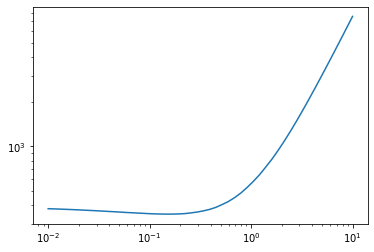

In [38]:
f0 = [(x['f']) for x in profiles[0]]
f0r = [np.exp(-(f0i-min(f0))) for f0i in f0]
plt.loglog(np.logspace(-2, 1, num=50).flatten(), f0)

In [39]:
list(zip(range(50), np.logspace(-2, 1, num=50),f0r))

[(0, 0.01, DM(4.7888e-14)),
 (1, 0.011513953993264475, DM(1.67066e-13)),
 (2, 0.013257113655901088, DM(6.35822e-13)),
 (3, 0.015264179671752334, DM(2.64096e-12)),
 (4, 0.017575106248547922, DM(1.19789e-11)),
 (5, 0.020235896477251575, DM(5.93342e-11)),
 (6, 0.023299518105153717, DM(3.36322e-10)),
 (7, 0.02682695795279726, DM(1.86845e-09)),
 (8, 0.030888435964774818, DM(1.2986e-08)),
 (9, 0.03556480306223128, DM(8.91437e-08)),
 (10, 0.040949150623804255, DM(6.44659e-07)),
 (11, 0.04714866363457394, DM(3.99688e-06)),
 (12, 0.054286754393238594, DM(3.65617e-05)),
 (13, 0.06250551925273973, DM(0.000269912)),
 (14, 0.07196856730011521, DM(0.00137748)),
 (15, 0.08286427728546843, DM(0.0080475)),
 (16, 0.09540954763499938, DM(0.0574564)),
 (17, 0.10985411419875583, DM(0.221443)),
 (18, 0.12648552168552957, DM(0.592227)),
 (19, 0.14563484775012436, DM(1)),
 (20, 0.16768329368110083, DM(0.923237)),
 (21, 0.19306977288832497, DM(0.389854)),
 (22, 0.22229964825261944, DM(0.06055)),
 (23, 0.255954

In [40]:
a0 = linterp(0.011513953993264475, 0.013257113655901088, 0.145754, 0.152931, 0.15)
a1 = linterp( 0.2559547922699536, 0.29470517025518095, 0.314558, 0.115928,  0.15)
a0idx = [1, 2]
a1idx = [23, 24]

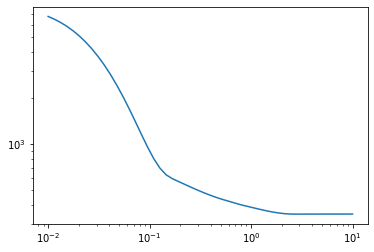

In [41]:
f1 = [(x['f']) for x in profiles[1]]
f1r = [np.exp(-(f1i-min(f1))) for f1i in f1]
plt.loglog(np.logspace(-2, 1, num=50).flatten(), f1)

In [42]:
list(zip(range(50), np.logspace(-2, 1, num=50),f1r))

[(0, 0.01, DM(0)),
 (1, 0.011513953993264475, DM(0)),
 (2, 0.013257113655901088, DM(0)),
 (3, 0.015264179671752334, DM(0)),
 (4, 0.017575106248547922, DM(0)),
 (5, 0.020235896477251575, DM(0)),
 (6, 0.023299518105153717, DM(0)),
 (7, 0.02682695795279726, DM(0)),
 (8, 0.030888435964774818, DM(0)),
 (9, 0.03556480306223128, DM(0)),
 (10, 0.040949150623804255, DM(0)),
 (11, 0.04714866363457394, DM(0)),
 (12, 0.054286754393238594, DM(0)),
 (13, 0.06250551925273973, DM(0)),
 (14, 0.07196856730011521, DM(0)),
 (15, 0.08286427728546843, DM(0)),
 (16, 0.09540954763499938, DM(1.08691e-263)),
 (17, 0.10985411419875583, DM(2.99502e-197)),
 (18, 0.12648552168552957, DM(6.40524e-151)),
 (19, 0.14563484775012436, DM(3.08987e-122)),
 (20, 0.16768329368110083, DM(7.34829e-107)),
 (21, 0.19306977288832497, DM(4.61223e-96)),
 (22, 0.22229964825261944, DM(1.04362e-85)),
 (23, 0.2559547922699536, DM(6.33619e-76)),
 (24, 0.29470517025518095, DM(7.87109e-67)),
 (25, 0.3393221771895328, DM(1.71723e-58)),
 (2

In [43]:
b0 = linterp(0.6866488450043002, 0.7906043210907697,0.105638 , 0.158776, 0.15)
b1 = linterp(2.8117686979742306,2.8117686979742308, 0.149, 0.151, 0.15)
b0idx = [30, 31]
b1idx = [40, 40]

In [44]:
r0int = [b0/a0, b0/a1, b1/a0, b1/a1]
r0int

[61.651772808241006, 2.6849982819238467, 224.13053183340259, 9.761115787718639]

In [45]:
def gets0(pdx, idx):
    return float(getx(profiles[pdx][idx]['x'])[0][0])
def means0(pdx, idxs):
    return np.mean([gets0(pdx, idx) for idx in idxs])
s0 = [means0(0, a0idx), means0(0, a1idx), means0(1,b0idx), means0(1,b1idx)]
def crossmean(axs, bxs):
    s = []
    for a in axs:
        for b in bxs:
            s.append(np.mean([a, b]))
    return s
s0mean = crossmean(s0[2:], s0[:2])

In [46]:
def rinft(r0,s0):
    f = lambda y: y/s0 - np.exp(r0*(y-s0)/s0) 
    sinf = brentq(f, 0, s0-1) 
    return s0-sinf
[rinft(r0x, s0x) for r0x, s0x in zip(r0int, s0mean)]

[5446.912005754491, 5006.933237255755, 5493.063221397988, 5523.421977084318]

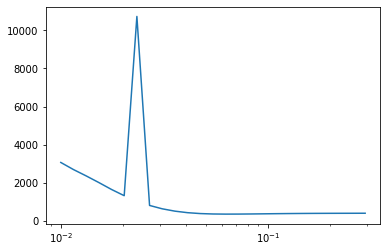

In [47]:
f2 = [(x['f']) for x in profiles[2]]
plt.semilogx(np.logspace(-2, 1, num=50).flatten()[:25], f2[:25])

In [48]:
def mod_seir(t, y, p):
    for i, yi in enumerate(y):
        if yi < 0:
            y[i] = 0 
    return seir(t, y, p)

In [49]:
from scipy.integrate import solve_ivp
tidx = 45
print(model.observation_times[tidx])
sol = solve_ivp(lambda t,y: mod_seir(t, y, getp(sols[idx]['x'])), [0, 150], [getx(sols[idx]['x'])[i][tidx] for i in range(5)], dense_output=True)
# solb = solve_ivp(lambda t,y: np.array(mod_seir(t, y, getp(sols[idx]['x']))), [0, -20], [getx(sols[idx]['x'])[i][tidx] for i in range(5)], method='BDF', dense_output=True)

87.27272727272727


In [50]:
[getx(sols[idx]['x'])[i][tidx] for i in range(5)]

[DM(2098.97), DM(1780.13), DM(624.542), DM(762.646), DM(1865.31)]

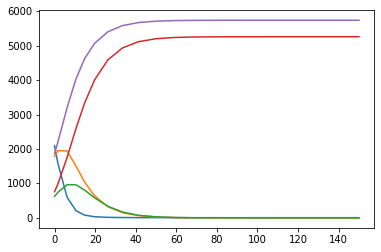

In [51]:
plt.plot(sol.t, sol.y[:,:].T)

In [52]:
model.observation_times[-1]

150.0

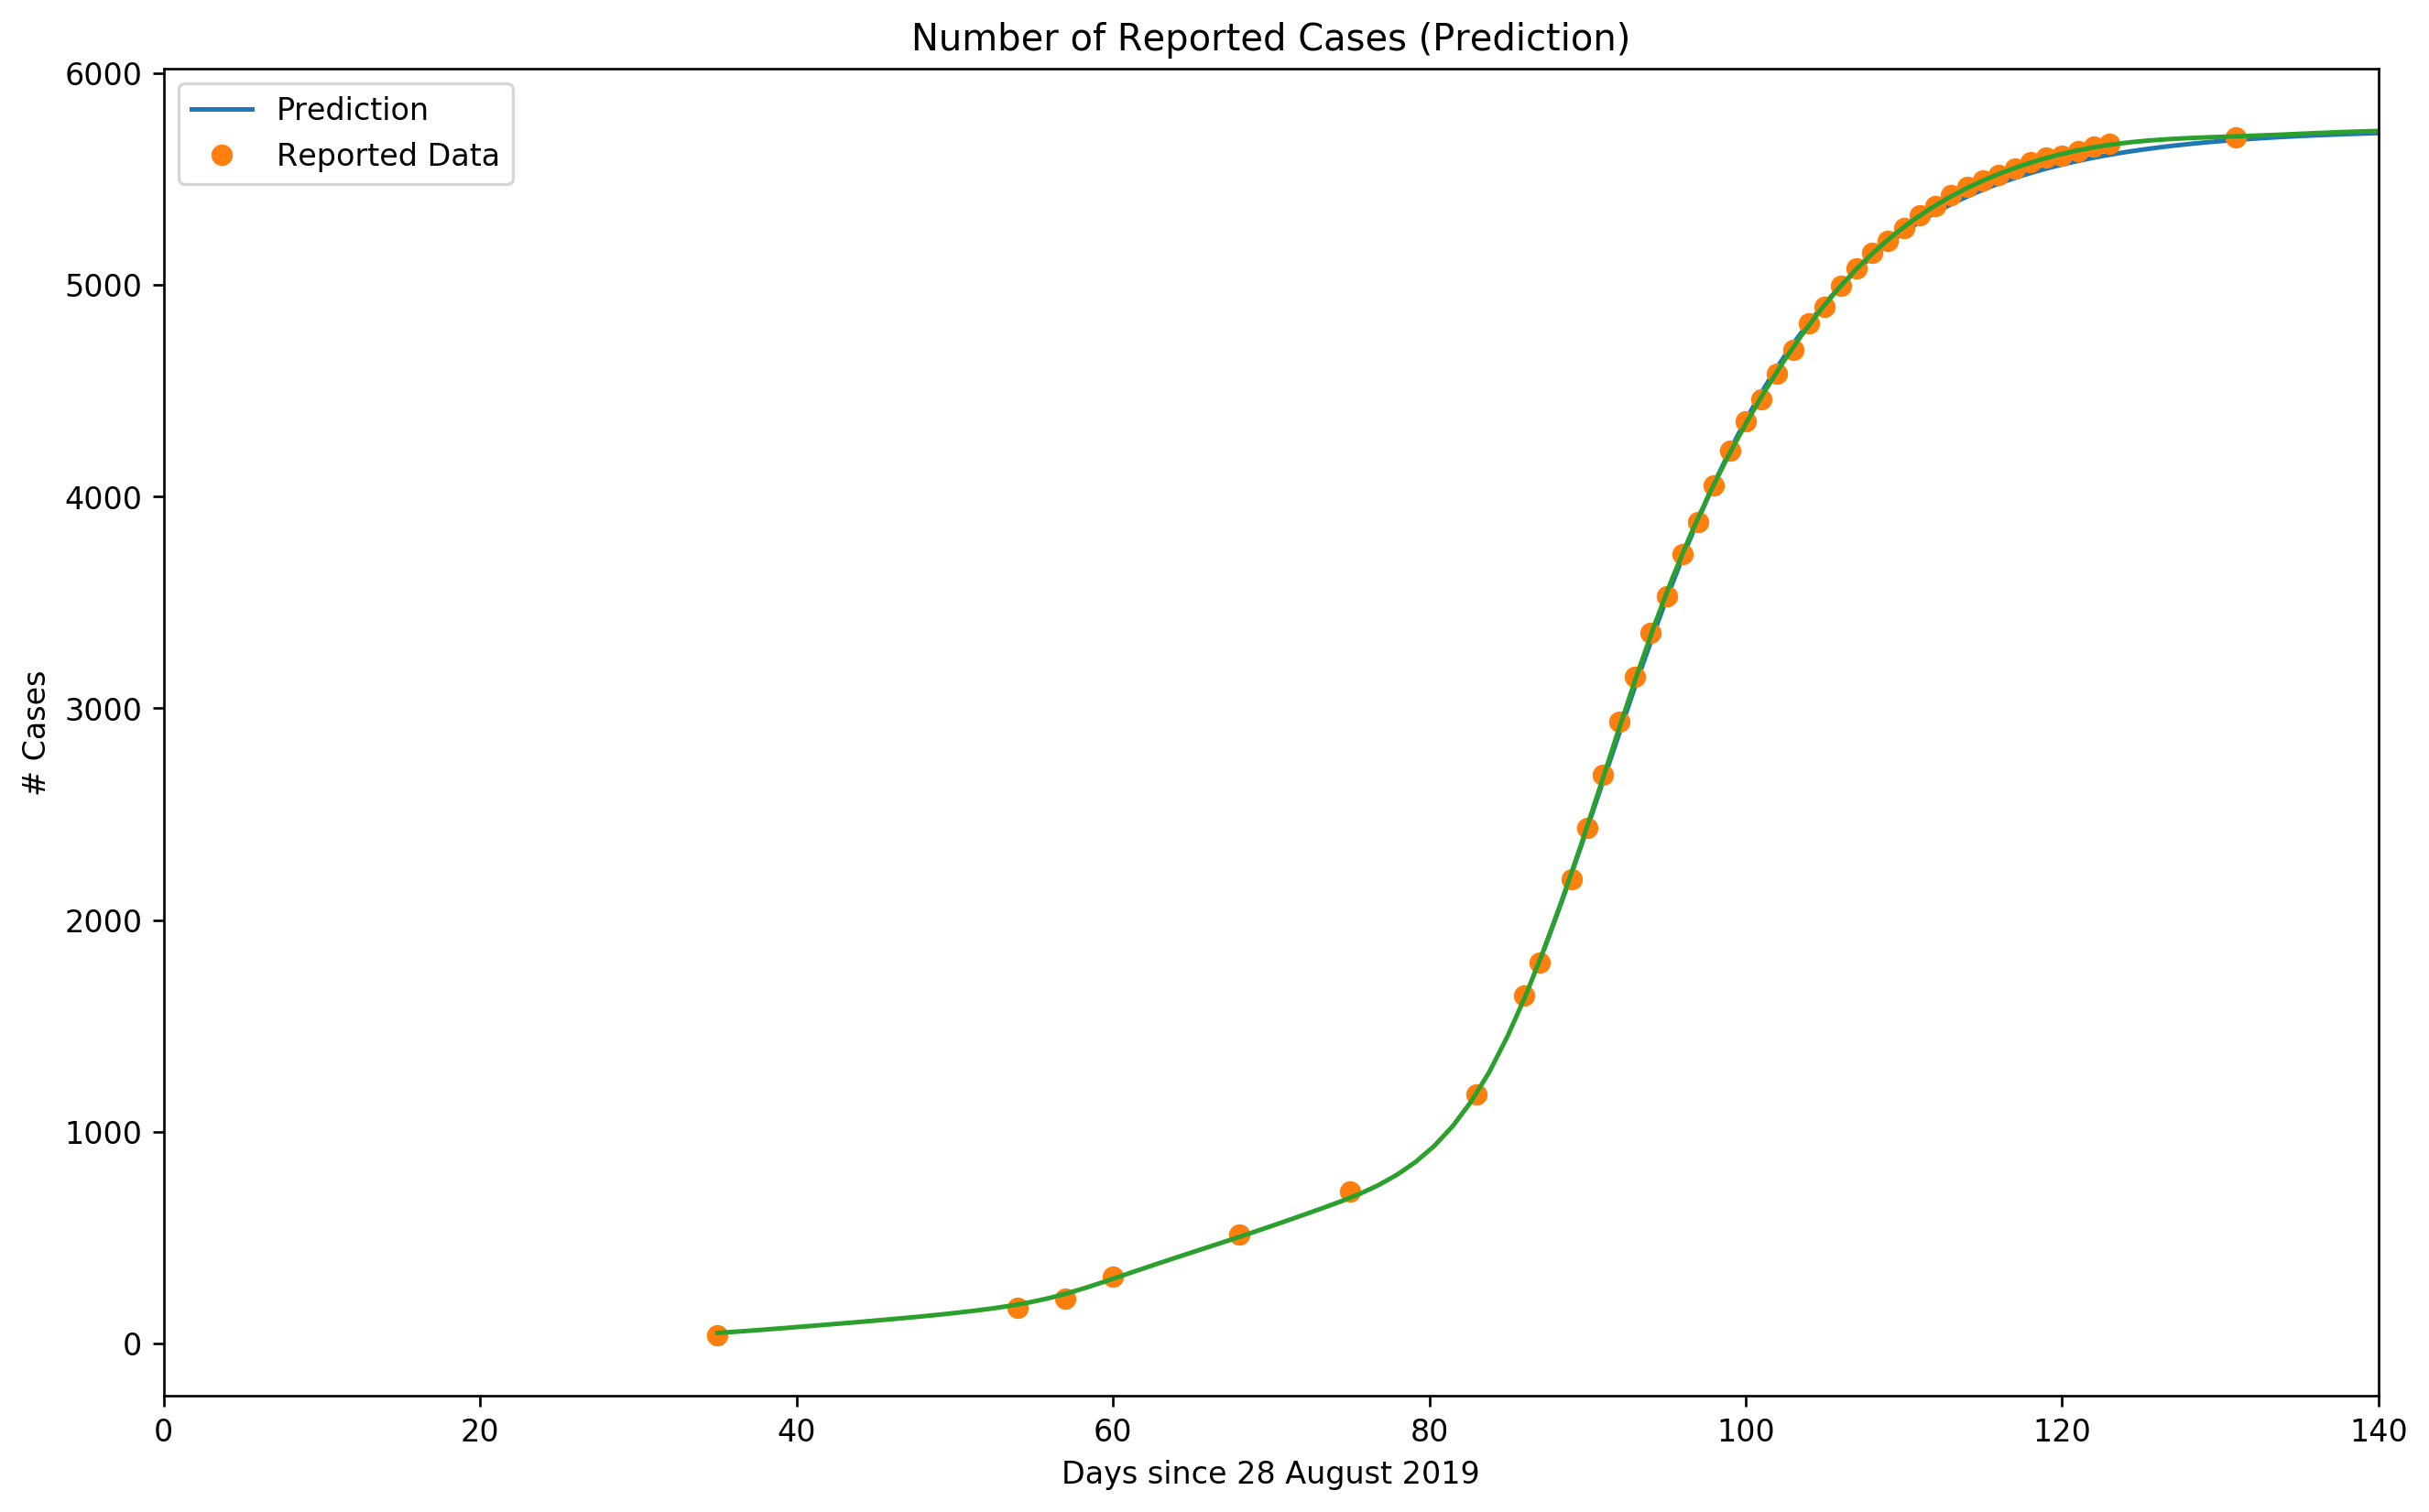

In [53]:
tfine = np.linspace(0, 150, 600)
# tbfine = np.linspace(0, -20, 20)
plt.figure(figsize=[13, 8], dpi=240)
# plt.plot(tbfine+model.observation_times[tidx], solb.sol(tbfine)[-1,:].T)
plt.plot(tfine+model.observation_times[tidx], sol.sol(tfine)[-1,:].T)
plt.plot(times, cumdata, 'o')
plt.xlim(0, 140)
plt.legend(["Prediction", "Reported Data"])
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Prediction)")

plt.plot(model.observation_times, getx(sols[idx]['x'])[4], label='Prediction')


In [54]:
rfin = sol.sol(tfine)[-1,-1]
rfin

5737.319165593064

In [55]:
ridx = np.argmin(np.abs(((1-(sol.sol(tfine)[-1,:])/rfin)*100) - 5))

In [56]:
tfine[ridx]

27.79632721202003

In [57]:
tfine[ridx]-(model.observation_times[-1]-model.observation_times[tidx])

-34.9309455152527

In [58]:
model.observation_times[-1]-model.observation_times[tidx]

62.727272727272734

In [59]:
historical_mortality = 0.02
current_mortality = D[-1]/cumdata[-1]
print(historical_mortality, current_mortality)

0.02 0.014569071441109355


In [60]:
rfin*historical_mortality

114.74638331186128

In [61]:
rfin*current_mortality

83.58741280397126

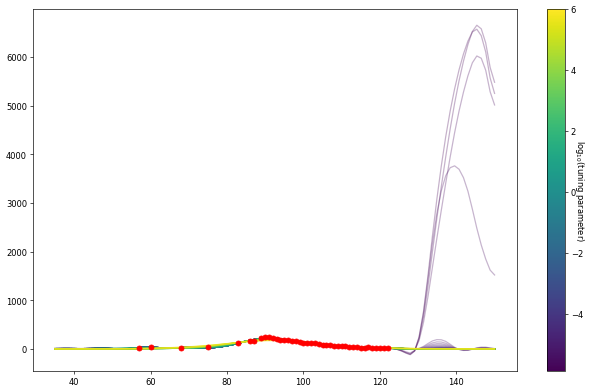

In [62]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors
i0, i1 = (1, -1)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

plt.figure(figsize=[13,8], dpi=60)
for i,p in enumerate(prange[i0:i1]):
    plt.plot(model.observation_times, np.gradient(getx(sols[i]['x'])[4].toarray().flatten(), model.observation_times),
            color=scalarMap.to_rgba(np.log10(p)), alpha=0.3)
plt.plot(times, np.gradient(cumdata, times), 'ro')
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)